In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import hte vaedr functions we have created
from vidr import VIDR
from PCAEval import PCAEval
from utils import *

#Import important modules
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(dpi = 150, frameon = True)
sns.set_style("dark")
sc.settings.figdir = "../figures"

In [2]:
kang_adata = sc.read_h5ad("../data/kang2018.h5ad")

In [3]:
kang_adata.obs["study"] = "Kang et al"

In [4]:
zheng_adata = sc.read_h5ad("../data/zheng2017.h5ad")

In [5]:
zheng_adata.obs["cell_type"].replace("CD4 T cells", "CD4T", inplace=True)
zheng_adata.obs["cell_type"].replace("B cells", "B", inplace=True)
zheng_adata.obs["cell_type"].replace("CD14+ Monocytes", "CD14+Mono", inplace=True)
zheng_adata.obs["cell_type"].replace("NK cells", "NK", inplace=True)
zheng_adata.obs["cell_type"].replace("CD8 T cells", "CD8T", inplace=True)
zheng_adata.obs["cell_type"].replace("Dendritic cells", "Dendritic", inplace=True)
zheng_adata.obs["cell_type"].replace("FCGR3A+ Monocytes", "FCGR3A+Mono", inplace=True)

In [6]:
adata = kang_adata.concatenate(zheng_adata)

In [7]:
adata.obs["study"].unique()

array(['Kang et al', 'Zheng et al'], dtype=object)

In [9]:
adata.obs["Study"] = ["Study A" if i == "Kang et al" else "Study B"]

NameError: name 'i' is not defined

In [10]:
study_labels = adata.obs["study"].values
cell_labels = adata.obs["cell_type"].values
adata.obs["study_cell"] = [f"{study}-{cell}" for study, cell in zip(study_labels, cell_labels)]

In [9]:
adata.obs["study_cell"]

index
AAACATACCAAGCT-1-stimulated-0            Kang et al-NK
AAACATACCCCTAC-1-stimulated-0     Kang et al-Dendritic
AAACATACCCGTAA-1-stimulated-0          Kang et al-CD4T
AAACATACCCTCGT-1-stimulated-0             Kang et al-B
AAACATACGAGGTG-1-stimulated-0          Kang et al-CD4T
                                         ...          
TTTCGAACTCTCAT-1-1-1             Zheng et al-CD14+Mono
TTTCTACTGAGGCA-1-1-1                     Zheng et al-B
TTTCTACTTCCTCG-1-1-1                     Zheng et al-B
TTTGCATGAGAGGC-1-1-1                     Zheng et al-B
TTTGCATGCCTCAC-1-1-1                  Zheng et al-CD4T
Name: study_cell, Length: 19516, dtype: object

In [11]:
#Training model
cell = "Zheng et al-B"
train_adata, test_adata = prepare_data(adata, "study_cell", "condition", cell, "stimulated", normalized = True)
vae = VIDR(train_adata, linear_decoder = False)

# vae.train(
# max_epochs=100,
# batch_size=128,
# early_stopping=True,
# early_stopping_patience=25)

# vae.save(f"../../data/VAE_OOD_Prediction_IFNB_7000g_{cell}.pt", overwrite = True)
vae = vae.load(f"../../data/VAE_OOD_Prediction_IFNB_7000g_{cell}.pt/", train_adata)

INFO     Using batches from adata.obs["condition"]                                                                 
INFO     Using labels from adata.obs["study_cell"]                                                                 
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 19516 cells, 5835 vars, 2 batches, 14 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
None
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                    

In [12]:
#UMAP Projection of latent space
latent_X = vae.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 19516 cells, 5835 vars, 2 batches, 14 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


In [13]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [14]:
from matplotlib import cm

In [22]:
latent_adata.obs["Study"] = ["Study A" if i == "Kang et al" else "Study B" for i in  adata.obs.study]
latent_adata.obs["Cell Type"] = adata.obs["cell_type"]
latent_adata.obs["Condition"] = adata.obs["condition"]

coolwarm


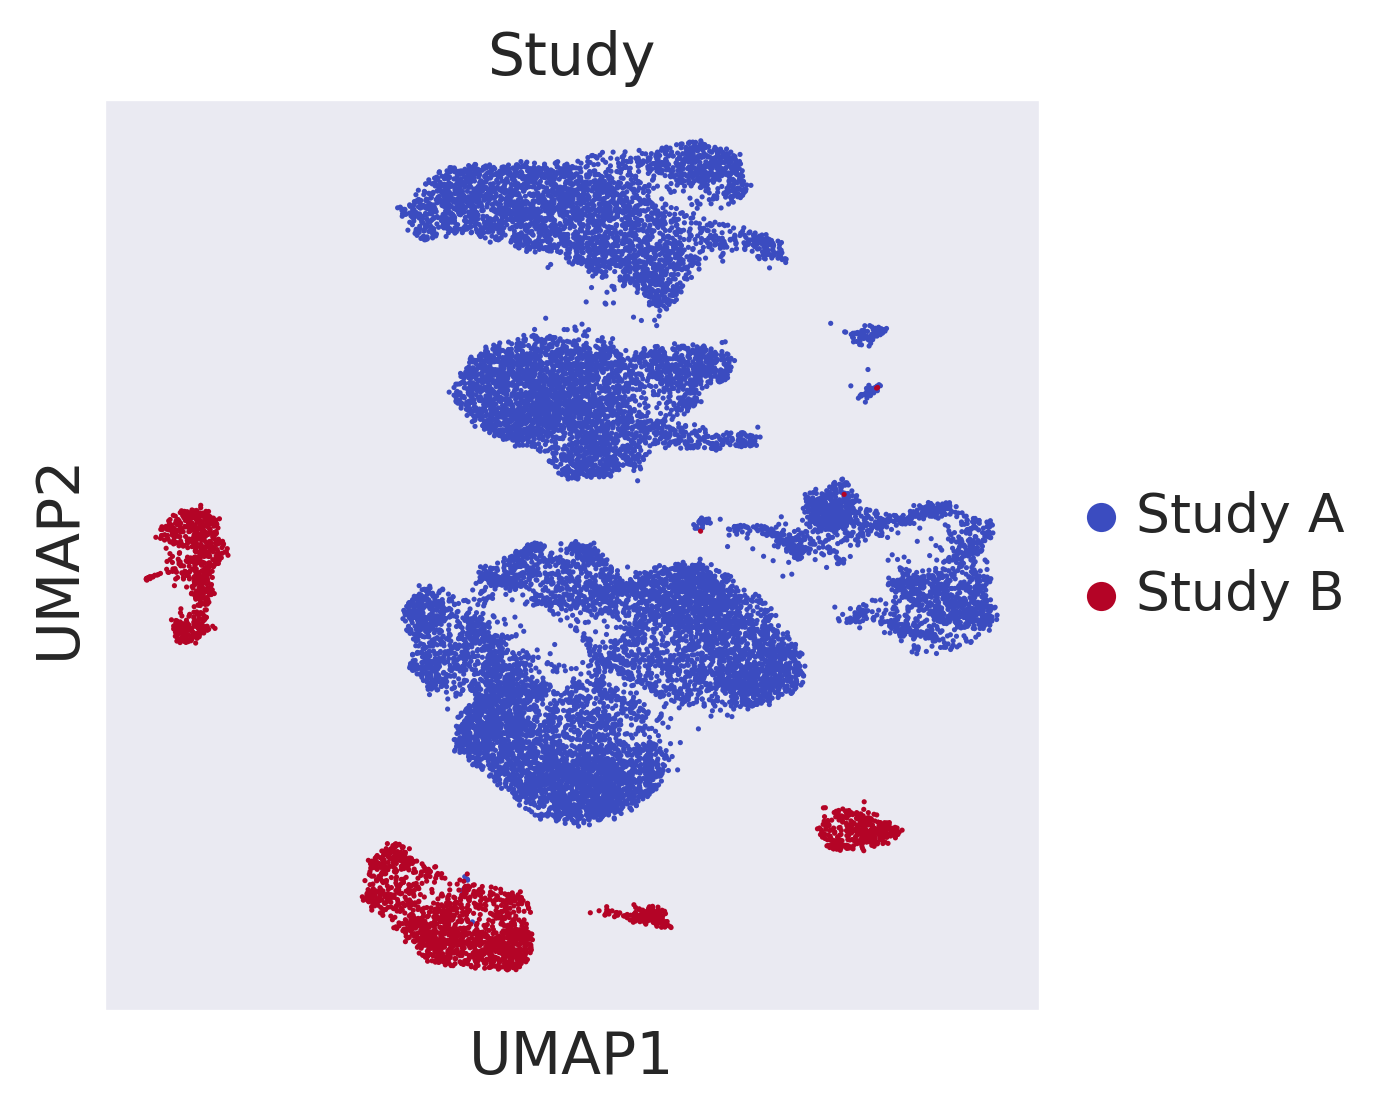

tab10


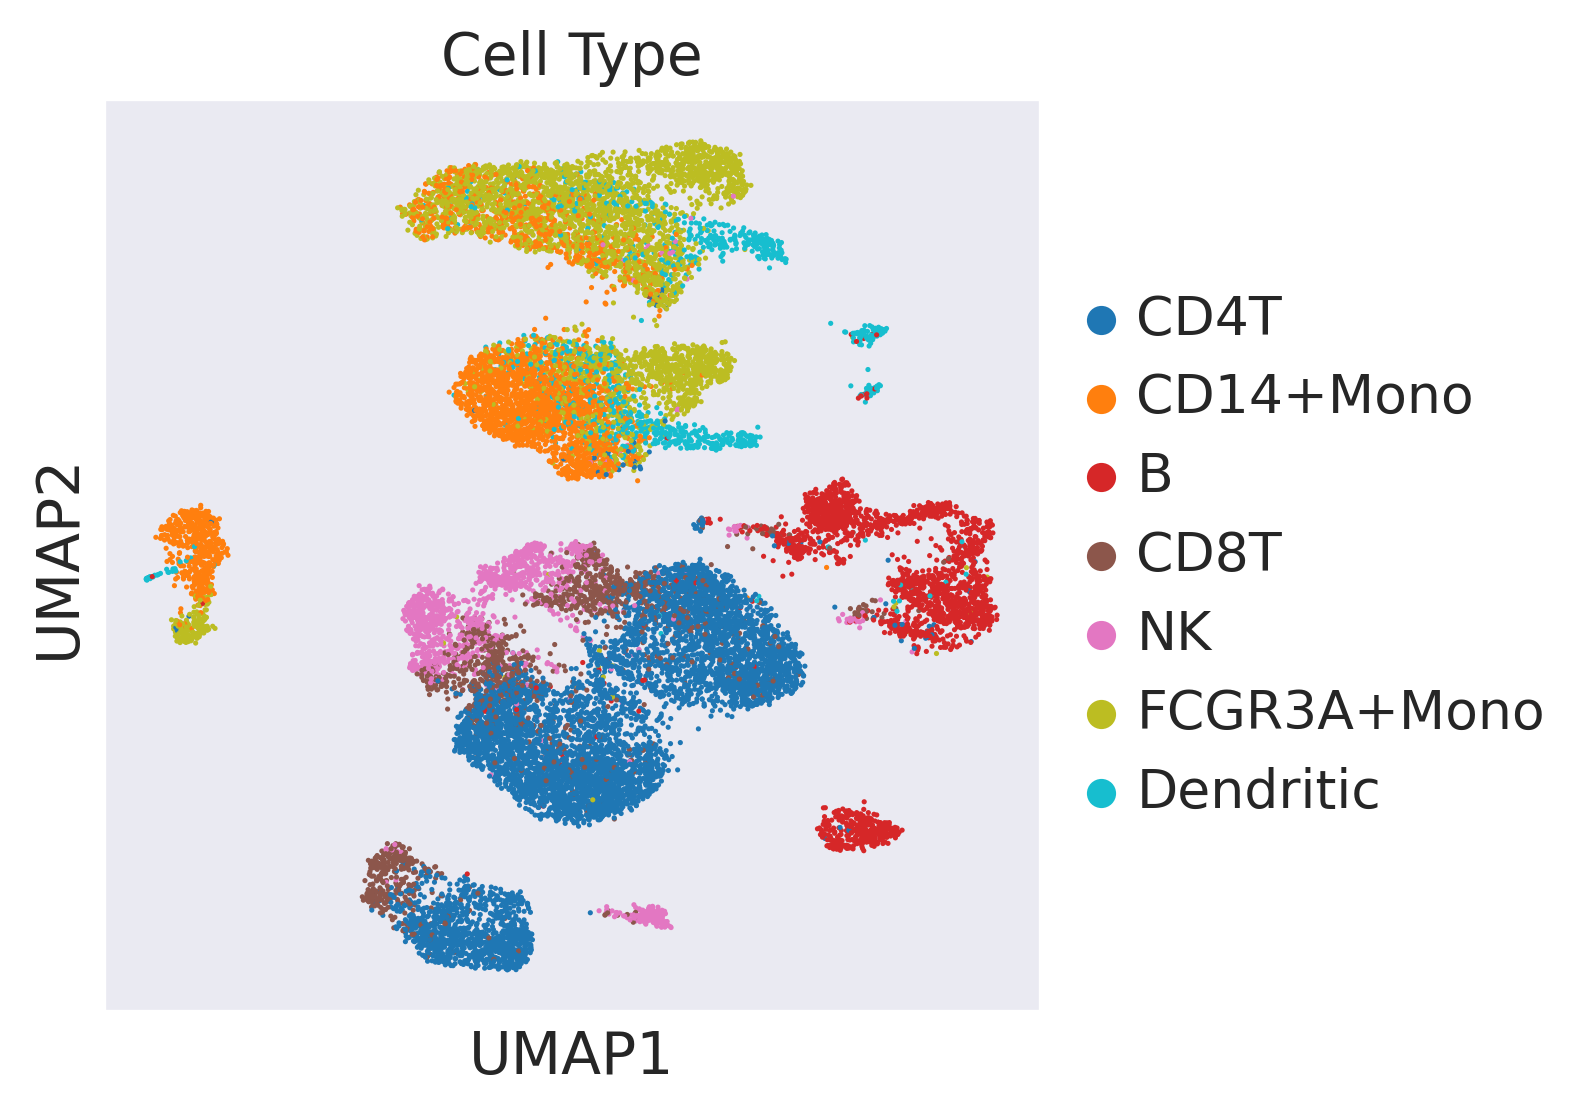

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725))


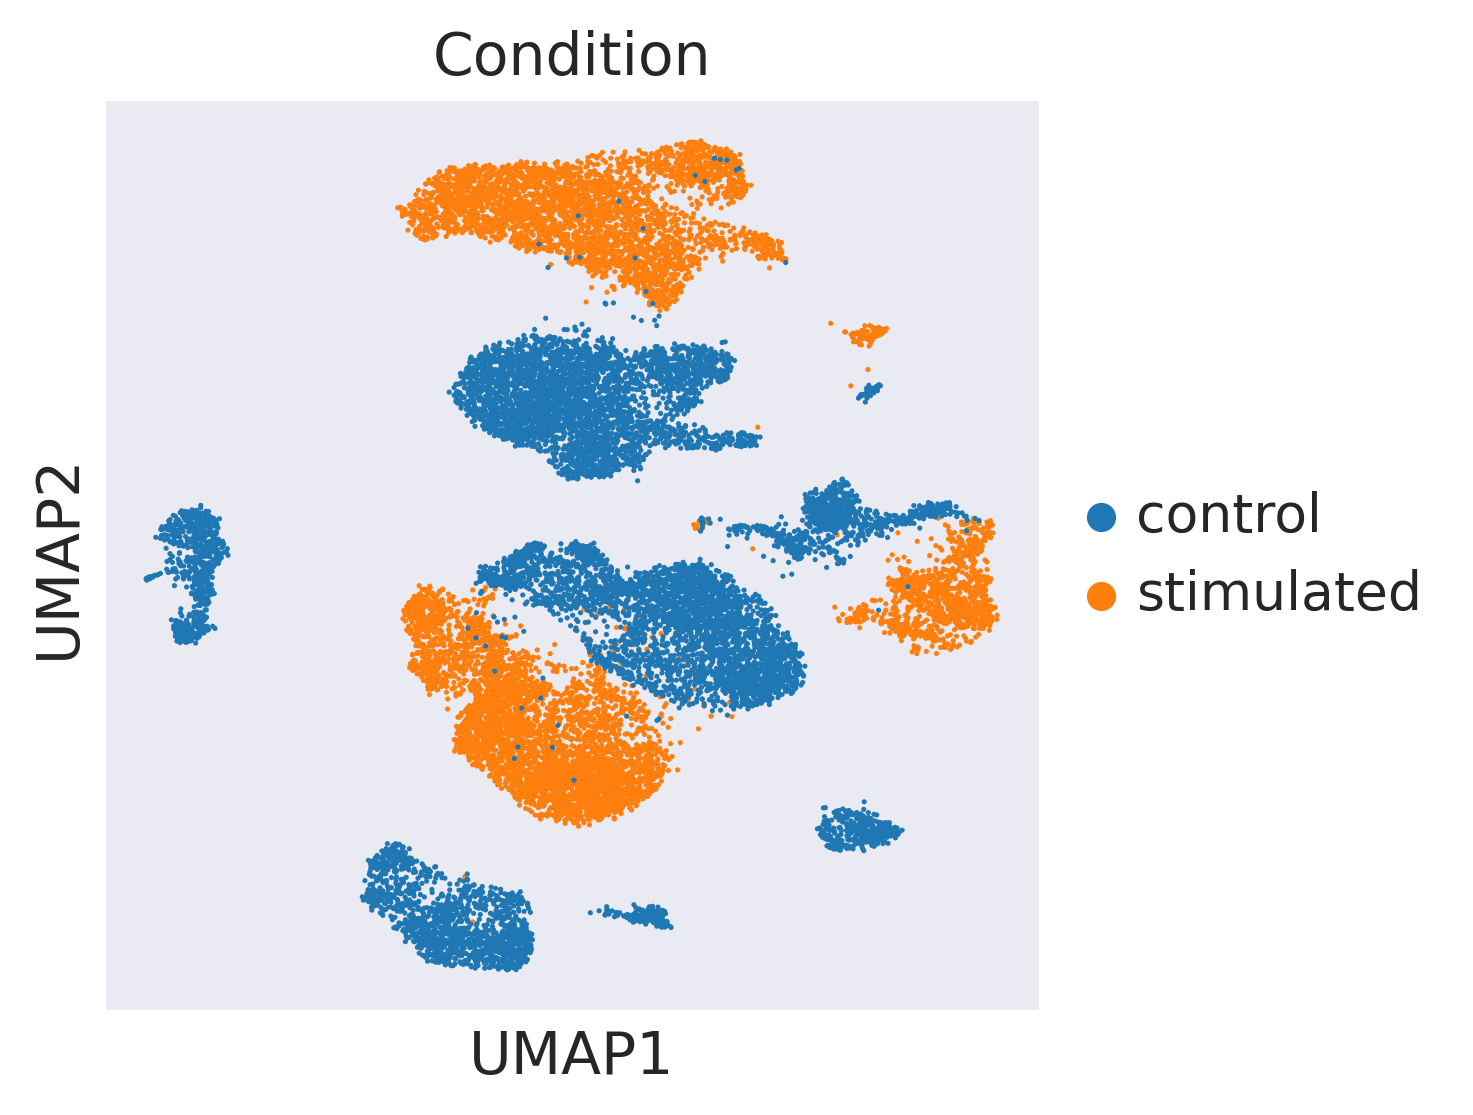

In [28]:
for idx, label in enumerate(['Study', 'Cell Type', 'Condition']):
    if label == "Cell Type":
        palette = "tab10"
    elif label == "Condition":
        palette = cm.tab10.colors[:2]
    else:
        palette = "coolwarm"
    print(palette)
    ax = sc.pl.umap(
        latent_adata,
        color = label,
        palette = palette
    )

In [29]:
ctrl_key = "control"
treat_key = "stimulated"
study_A_key = "Kang et al"
study_B_key = "Zheng et al"
cell_type_to_predict = "B"

In [30]:
cell_type_key = "cell_type"
treatment_key = "condition"
study_key = "study"

In [31]:
studyA = vae.adata[vae.adata.obs[study_key] == study_A_key]
studyB = vae.adata[vae.adata.obs[study_key] == study_B_key]

In [32]:
ctrl_x = studyA[studyA.obs[treatment_key] == ctrl_key]
treat_x = studyA[studyA.obs[treatment_key] == treat_key]

In [33]:
ctrl_x = random_sample(ctrl_x, cell_type_key)
treat_x = random_sample(treat_x, cell_type_key)

In [34]:
#Balancing across treatments 
new_adata = ctrl_x.concatenate(treat_x)
new_adata = random_sample(new_adata, treatment_key, max_or_min = "min", replacement = False)

In [35]:
#Densify Sparse Matrix
if sparse.issparse(new_adata.X):
        new_adata.X = new_adata.X.A

In [36]:
if sparse.issparse(new_adata.X):
            new_adata.X = new_adata.X.A

In [37]:
latent_X =  vae.get_latent_representation(new_adata)
latent_adata = sc.AnnData(X=latent_X, obs = new_adata.obs.copy())
#Get deltas and control centroids for each cell tpye in the training dataset
deltas = []
latent_centroids = []
cell_types = np.unique(latent_adata.obs[cell_type_key])
for cell_i in cell_types:
    if cell_i != cell_type_to_predict:
        latent_ctrl = latent_adata[(latent_adata.obs[cell_type_key] == cell_i) & (latent_adata.obs[treatment_key] == ctrl_key)]
        latent_treat = latent_adata[(latent_adata.obs[cell_type_key] == cell_i) & (latent_adata.obs[treatment_key] == treat_key)]
        ctrl_centroid = np.average(latent_ctrl.X, axis = 0)
        treat_centroid = np.average(latent_treat.X, axis = 0)
        delta = treat_centroid - ctrl_centroid
        deltas.append(delta)
        latent_centroids.append(ctrl_centroid)
lr = LinearRegression()
reg = lr.fit(latent_centroids, deltas)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 34118 cells, 5835 vars, 2 batches, 14 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


In [38]:
scVIDR_pred_l = []
for cell_i in cell_types:
    print(cell_i)
    studyB_i = studyB[studyB.obs[cell_type_key] == cell_i]
    print(studyB_i)
    latent_cd_i = vae.get_latent_representation(studyB_i)
    scVIDR_delta_i = reg.predict([np.average(latent_cd_i, axis = 0)])[0]
    print(scVIDR_delta_i)
    treat_pred = scVIDR_delta_i + latent_cd_i
    predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
    scvidr_pred_i = sc.AnnData(X=predicted_cells , obs=studyB_i.obs, var=studyB_i.var.copy())
    scVIDR_pred_l.append(scvidr_pred_i)

B
View of AnnData object with n_obs × n_vars = 342 × 5835
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', 'study', 'percent_mito', 'batch', 'study_cell', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_symbol-0', 'n_cells-0', 'gene_symbol-0-1', 'n_cells-0-1', 'n_cells-1-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    uns: '_scvi'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
INFO     Received view of anndata, making copy.                                                                    
[-1.1875428  -0.9810512  -0.9034028   1.0080755  -2.822612    1.9888012
  2.74437    -0.33823186 -3.4023392   0.8470795  -0.03016177  1.3572129
 -0.8457316  -3.4008465   1.213508    1.0370331  -1.1089827  -1.5722971
  1.2053063   2.8660097   0.45004186  1.5204619  -1.0602865  -1.1114156
  0.301614    0.70524514  0.9615224  -0.6817345   2.7672496  -2.3375173
  0.18527424  2.4289594   0.24793583 -0.726011    0.42058218  0.5782151
  1.1462336 

[-1.7507269  -2.0251951  -1.0004256   0.6215048  -2.6961694   2.5163913
  2.233182   -0.9243959  -4.2248135   0.7616194   0.1512892   1.628818
 -1.3772464  -3.6566553   0.21030664  2.334725   -2.0704243  -1.9551375
  2.3029413   2.1578624   1.1967856   1.9416854  -0.75561595 -1.1722921
  0.3131122   2.2668047   0.35558715 -0.15497762  2.7351866  -1.7738625
  0.90962064  3.1797671   1.1386478  -2.0568929   0.19551957  0.52583283
  1.8522154   0.1640752   1.8178735   1.6352586   1.741484   -2.7083254
 -0.22563541  0.04523547 -0.5229899  -1.5770161  -1.1166457   1.4350513
 -2.2068095   2.5788107   1.8145161   0.6875453  -0.1614443   1.7387826
  0.18244092  0.7726072  -2.1279576  -2.3847575   3.9793904  -3.6577697
 -2.9463494   1.238225   -2.3815203  -0.20130536  1.7445174   1.7319673
  0.5739794   2.409211    1.3074114  -0.8947525  -1.1232944  -1.1959589
 -0.1540758  -1.0092752  -0.35531533  2.278411   -1.395221    1.1637367
  2.704504    2.231069    1.1392927   0.51090765 -1.9482629   2.

In [39]:
scVIDR_pred = scVIDR_pred_l[0].concatenate(scVIDR_pred_l[1:])

In [40]:
scVIDR_pred.obs["condition"] = "stimulated - scVIDR Prediction"

In [41]:
eval_adata = train_adata.concatenate(scVIDR_pred)

In [42]:
sc.pp.neighbors(eval_adata)
sc.tl.umap(eval_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [46]:
eval_adata.obs["Study"] = ["Study A" if i == "Kang et al" else "Study B" for i in  eval_adata.obs.study]
eval_adata.obs["Cell Type"] = eval_adata.obs["cell_type"]
eval_adata.obs["Condition"] = eval_adata.obs["condition"]

coolwarm


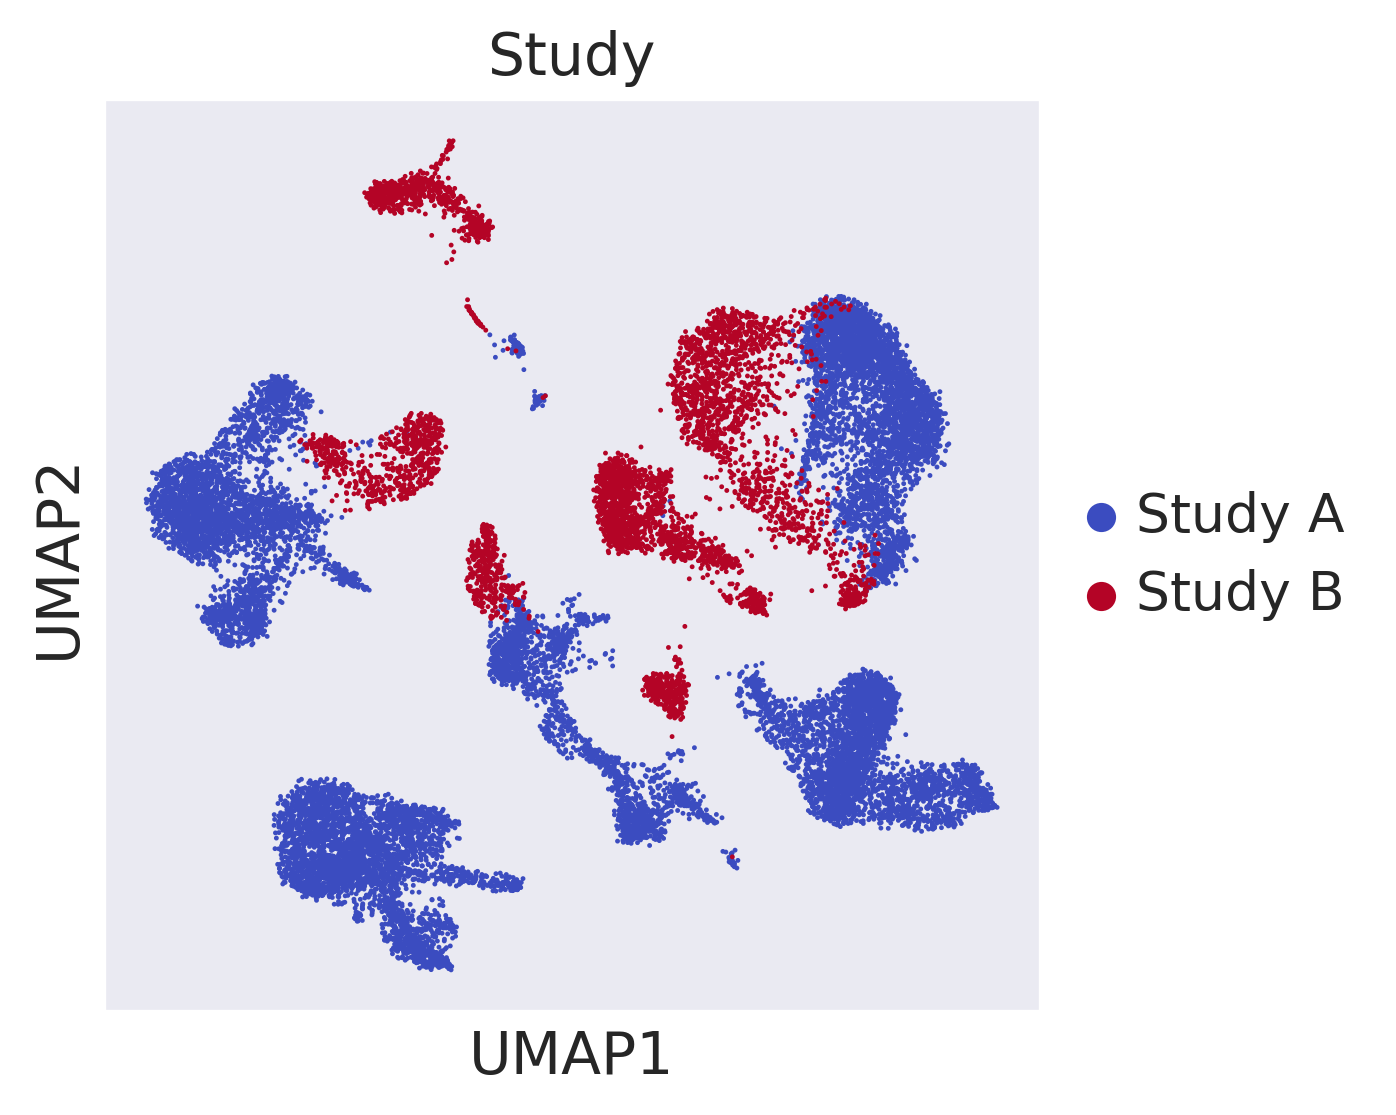

tab10


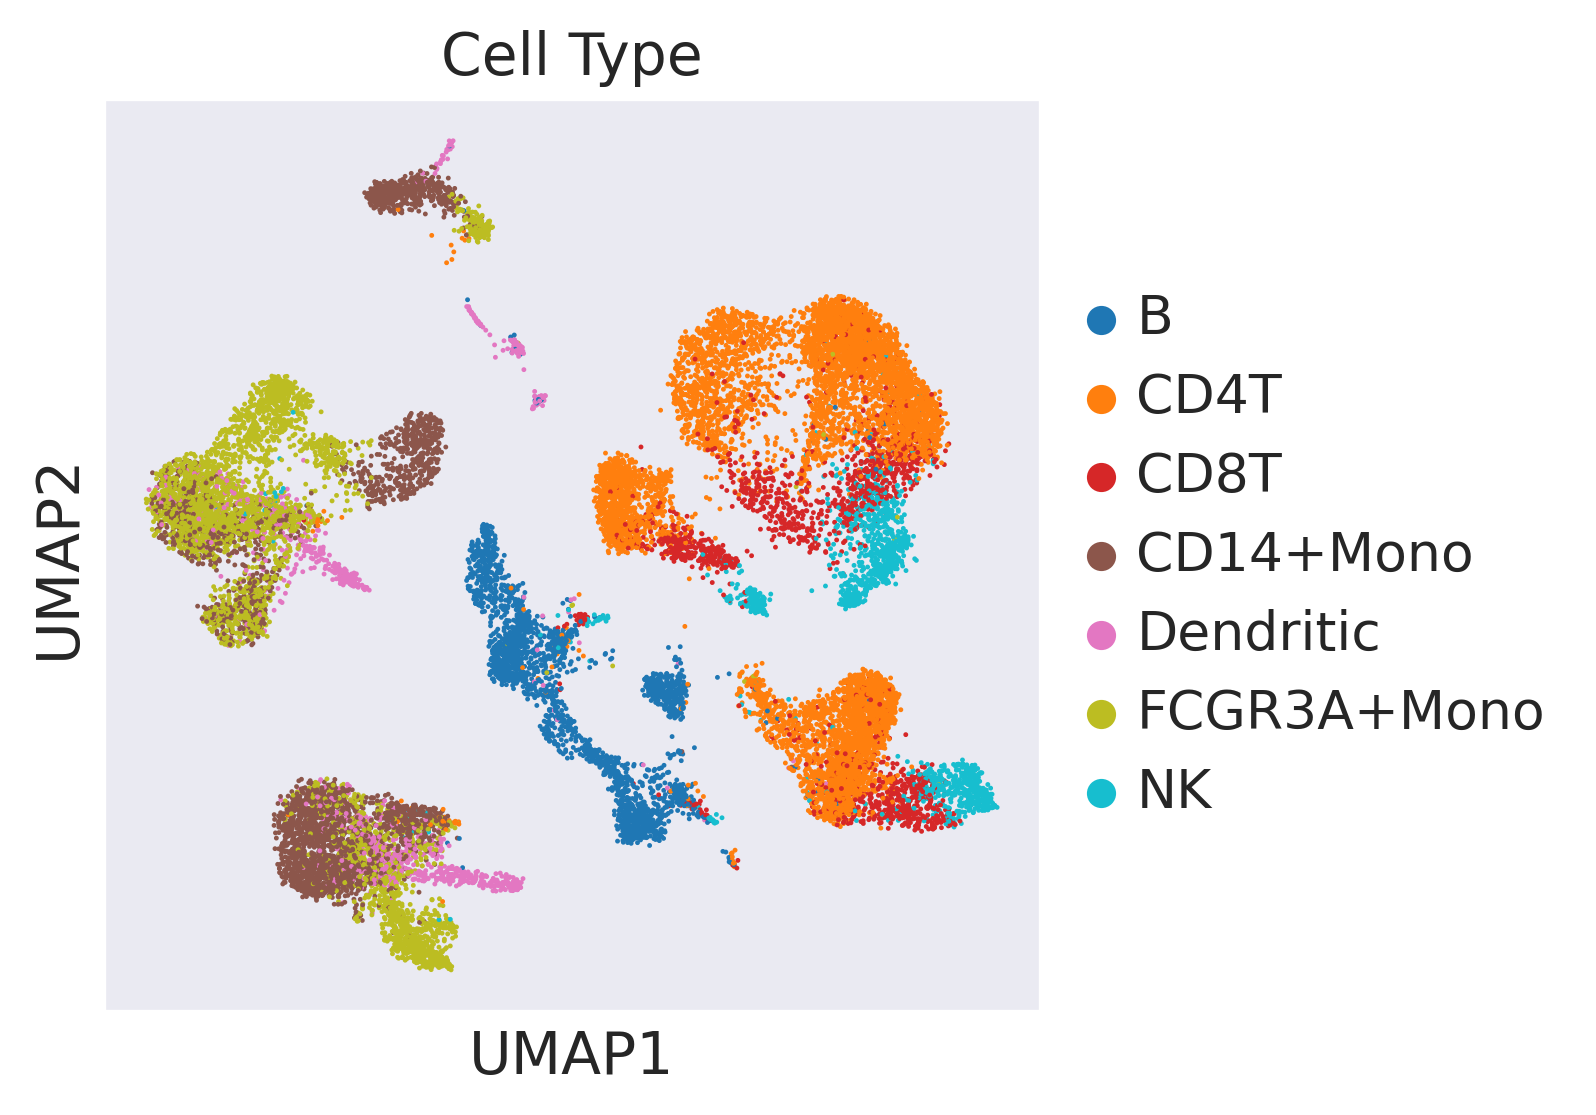

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313))


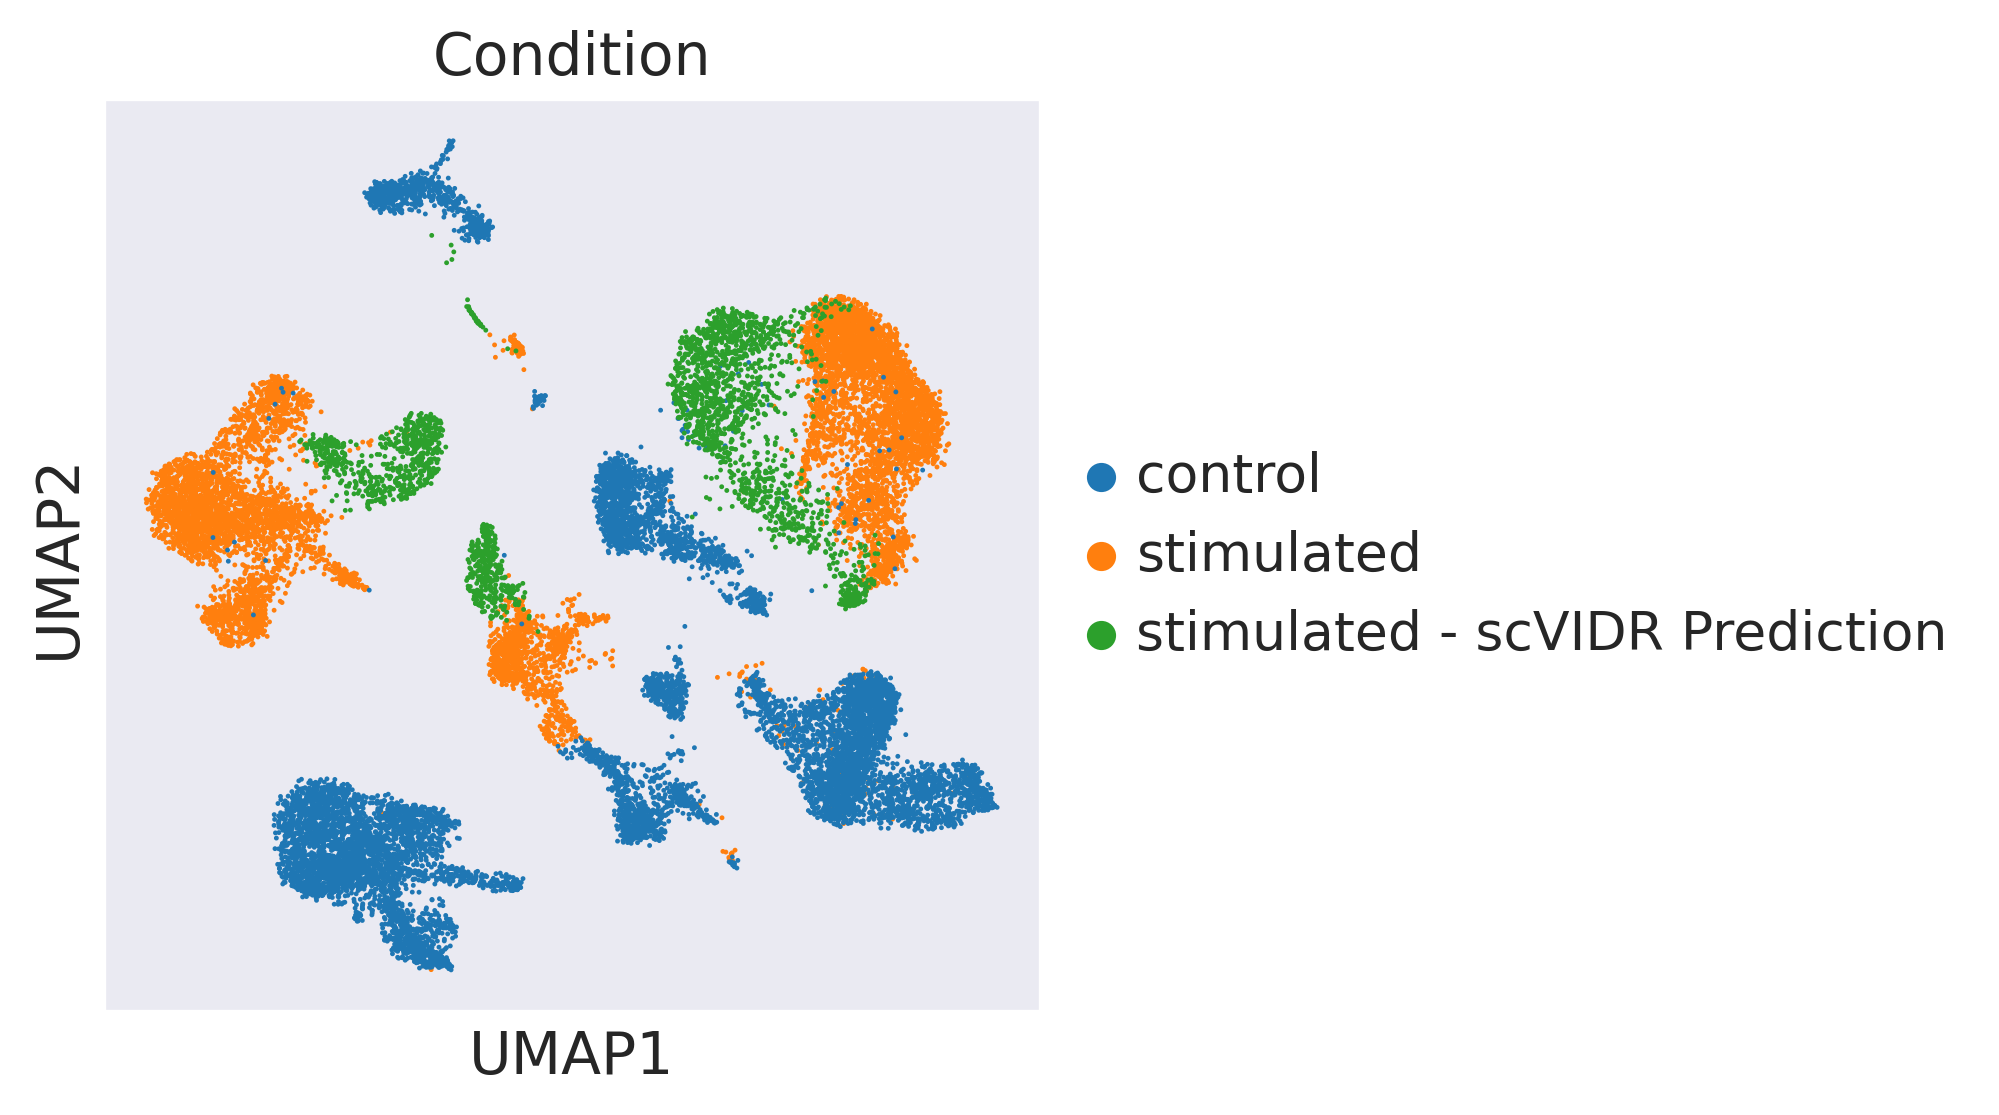

In [49]:
for idx, label in enumerate(['Study', 'Cell Type', 'Condition']):
    if label == "Cell Type":
        palette = "tab10"
    elif label == "Condition":
        palette = cm.tab10.colors[:3]
    else:
        palette = "coolwarm"
    print(palette)
    ax = sc.pl.umap(
        eval_adata,
        color = label,
        palette = palette
    )

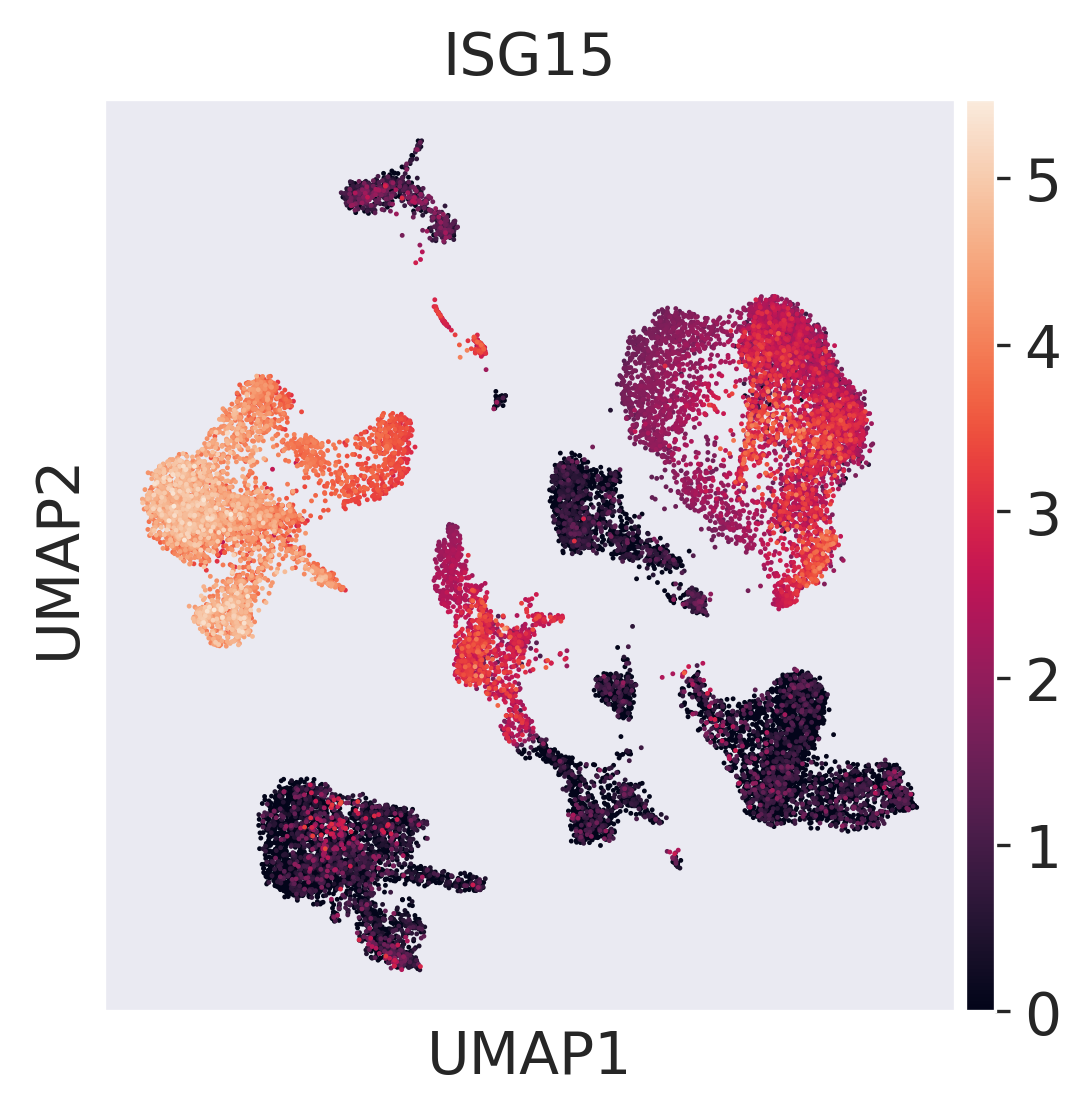

In [48]:
sc.pl.umap(
    eval_adata,
    color = "ISG15"
)

B
INFO     Received view of anndata, making copy.                                                                    


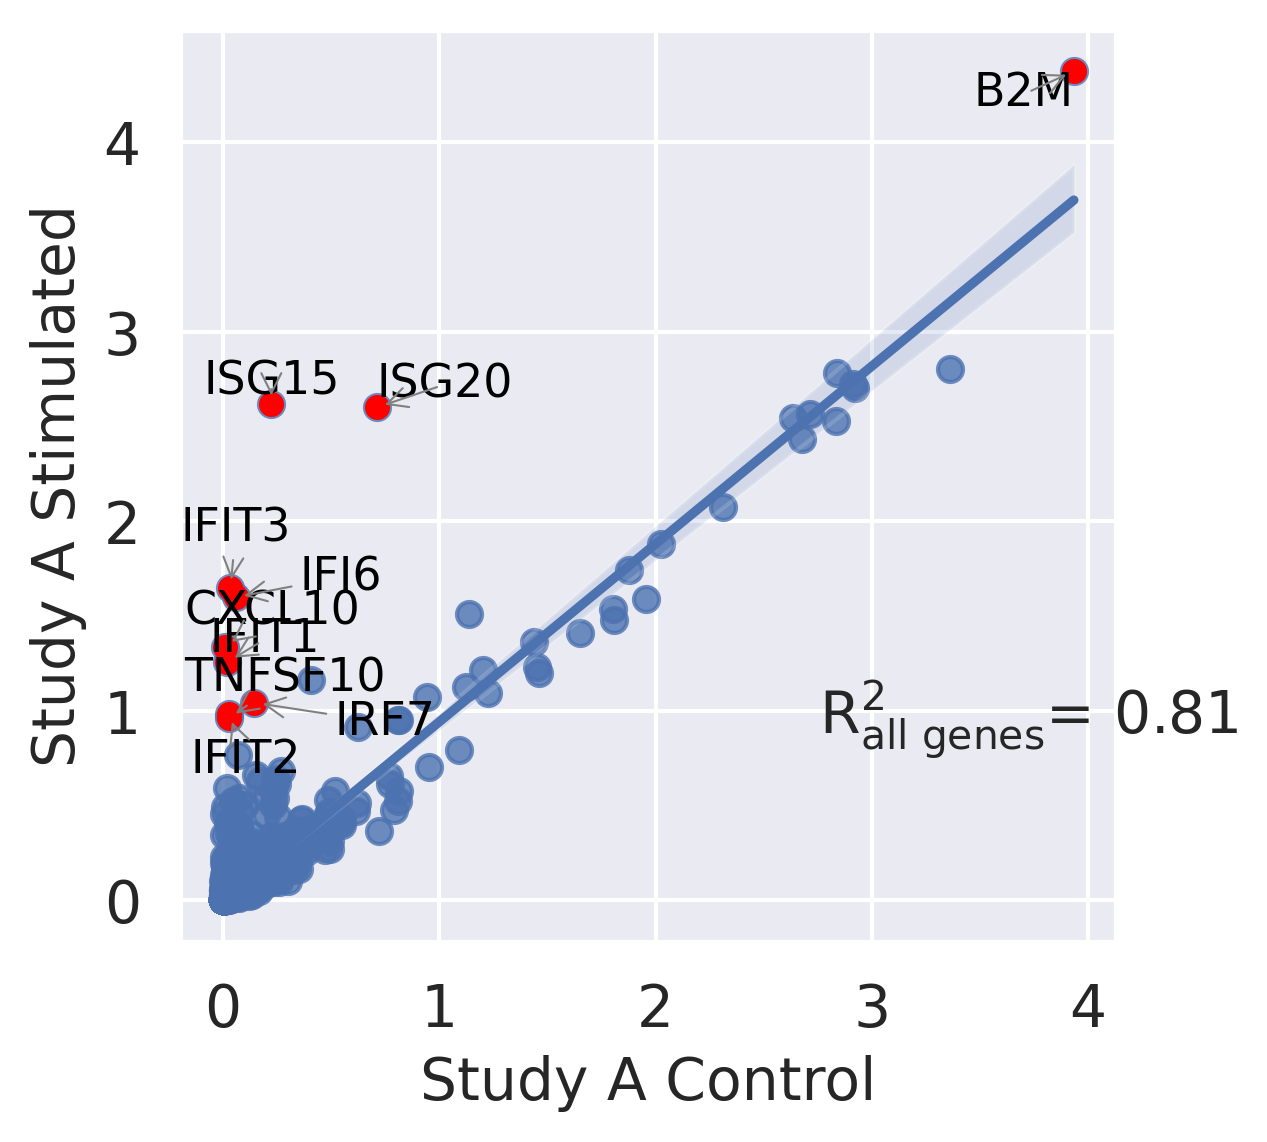

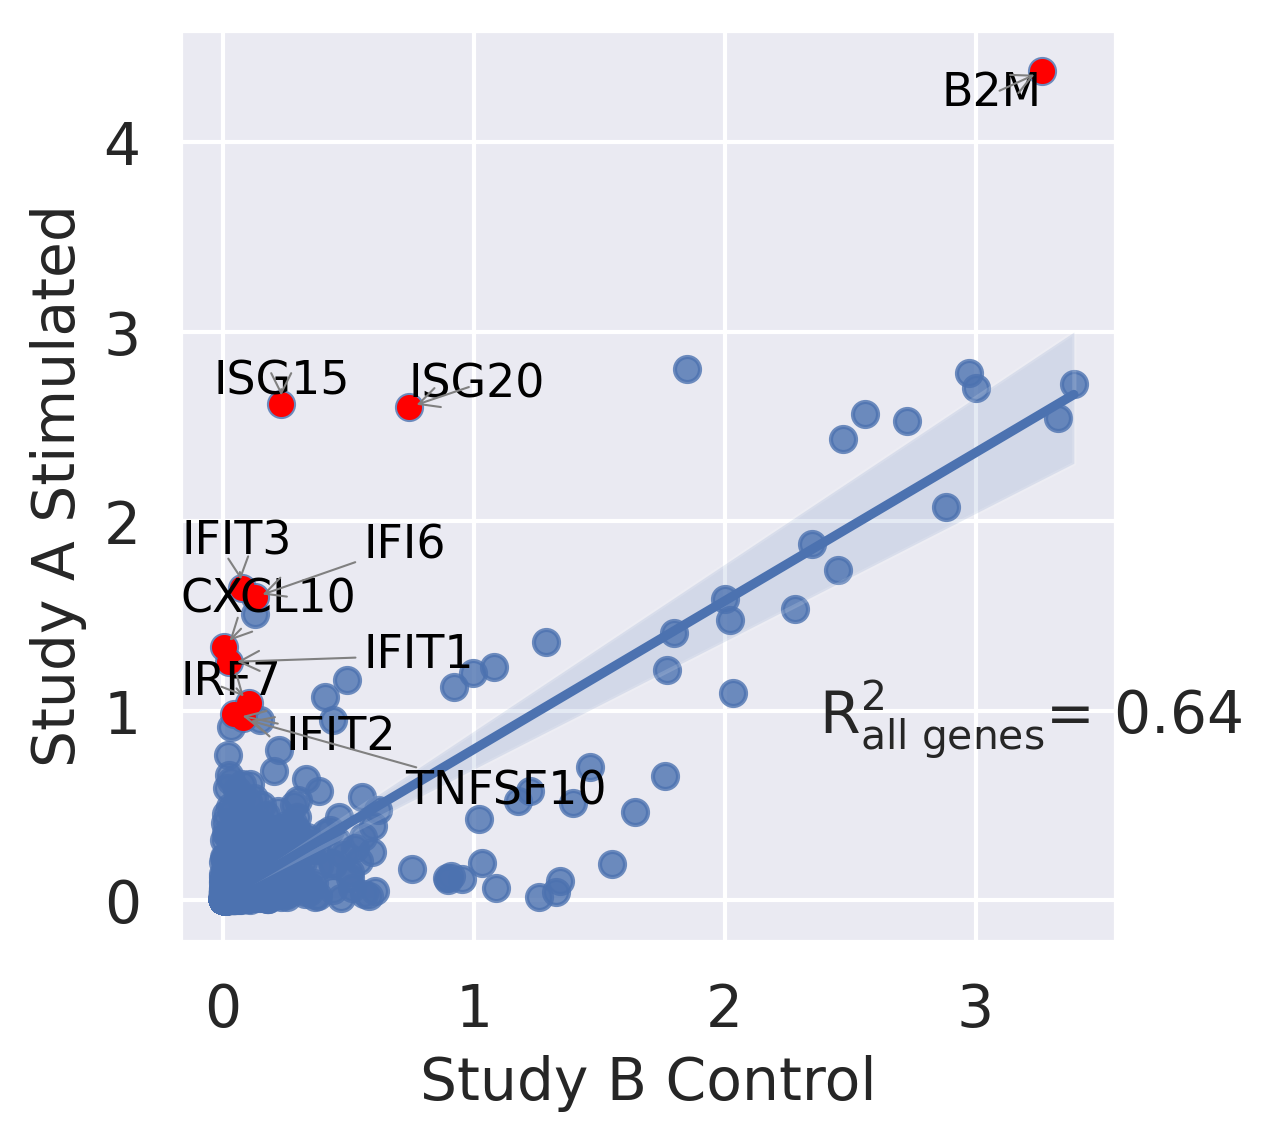

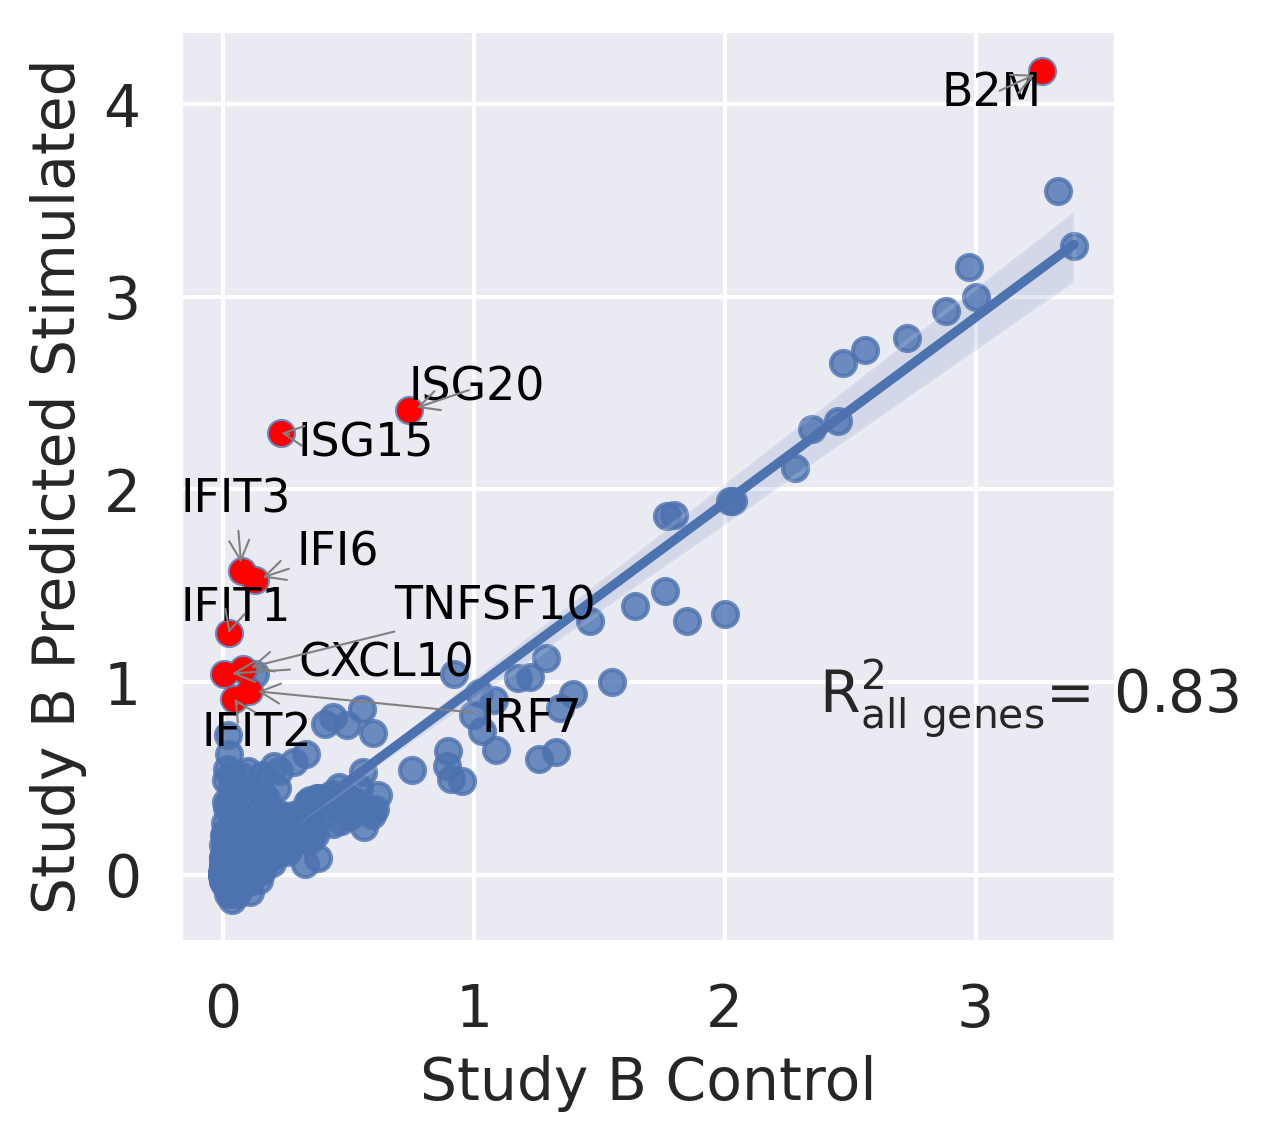

CD14+Mono
INFO     Received view of anndata, making copy.                                                                    


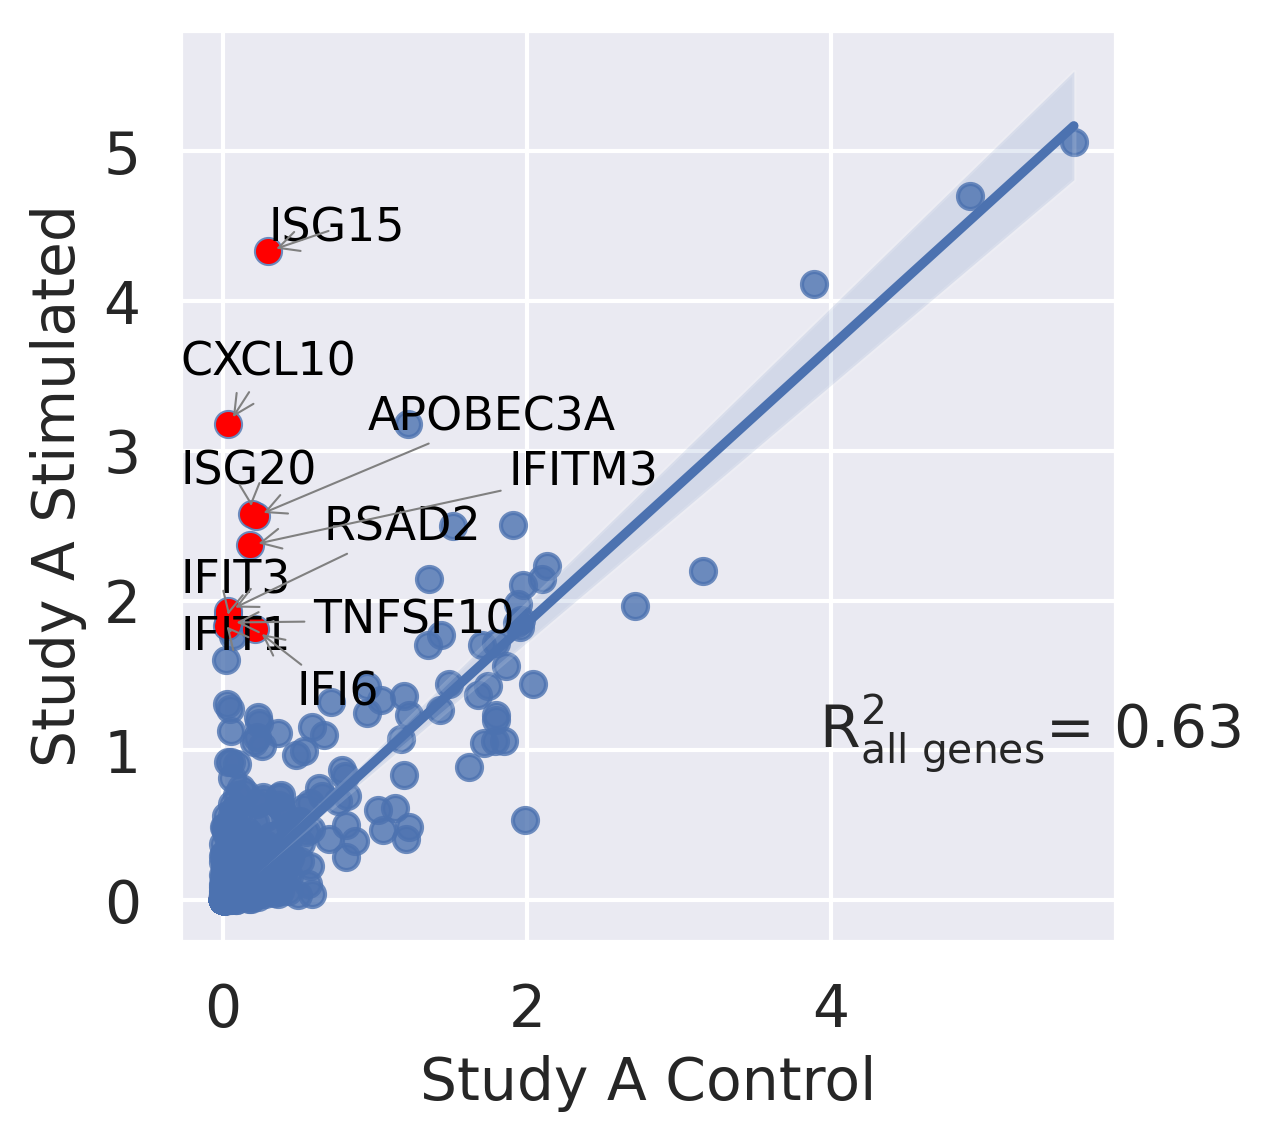

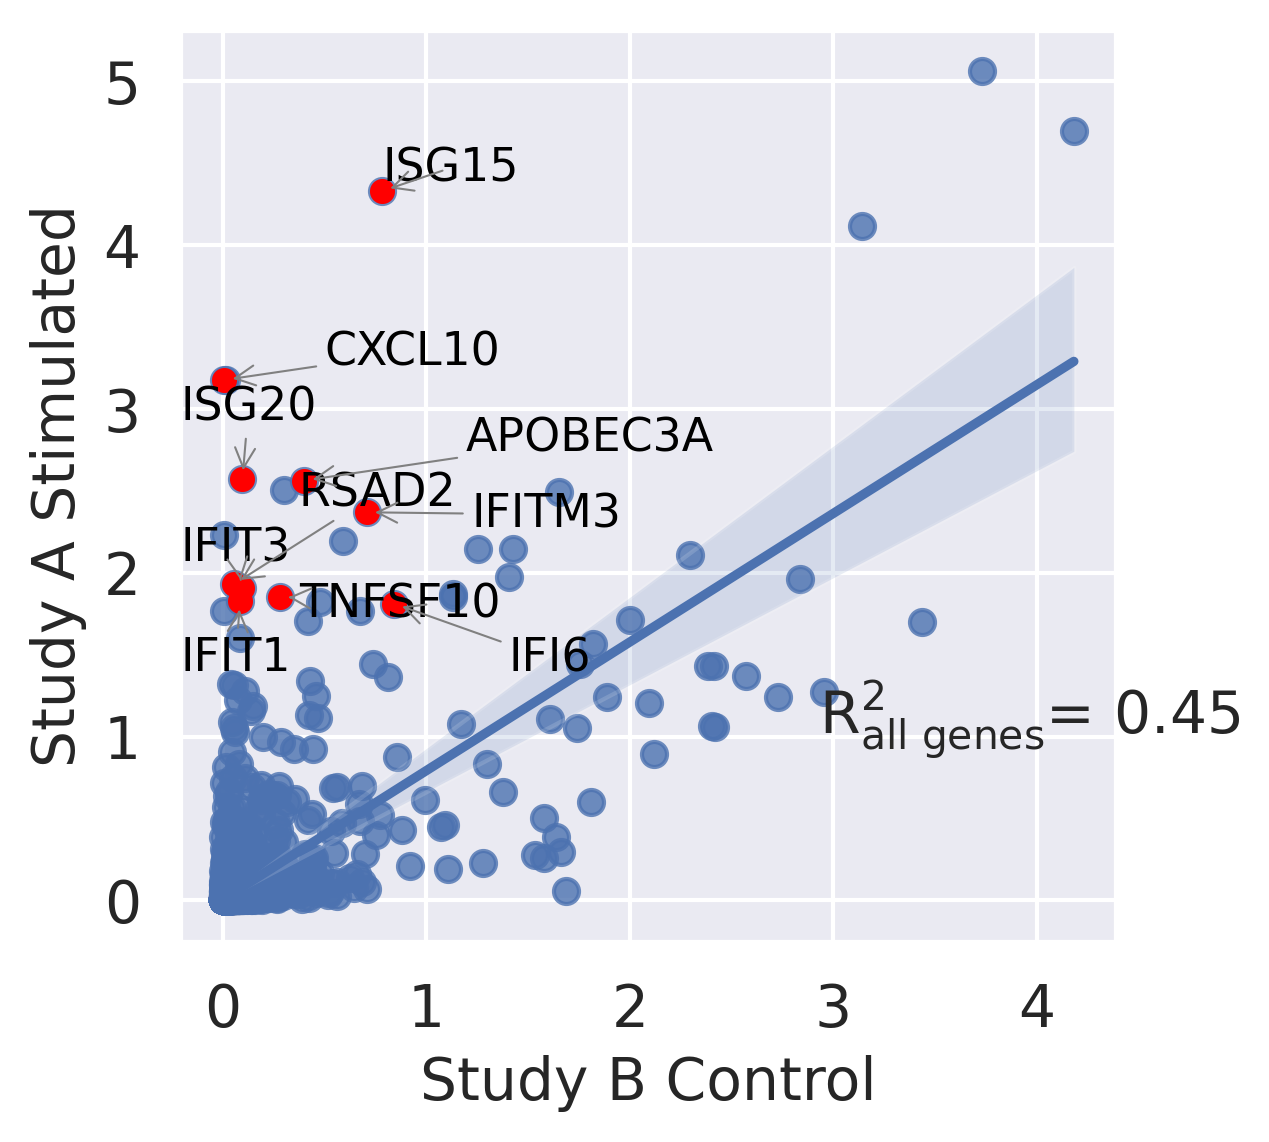

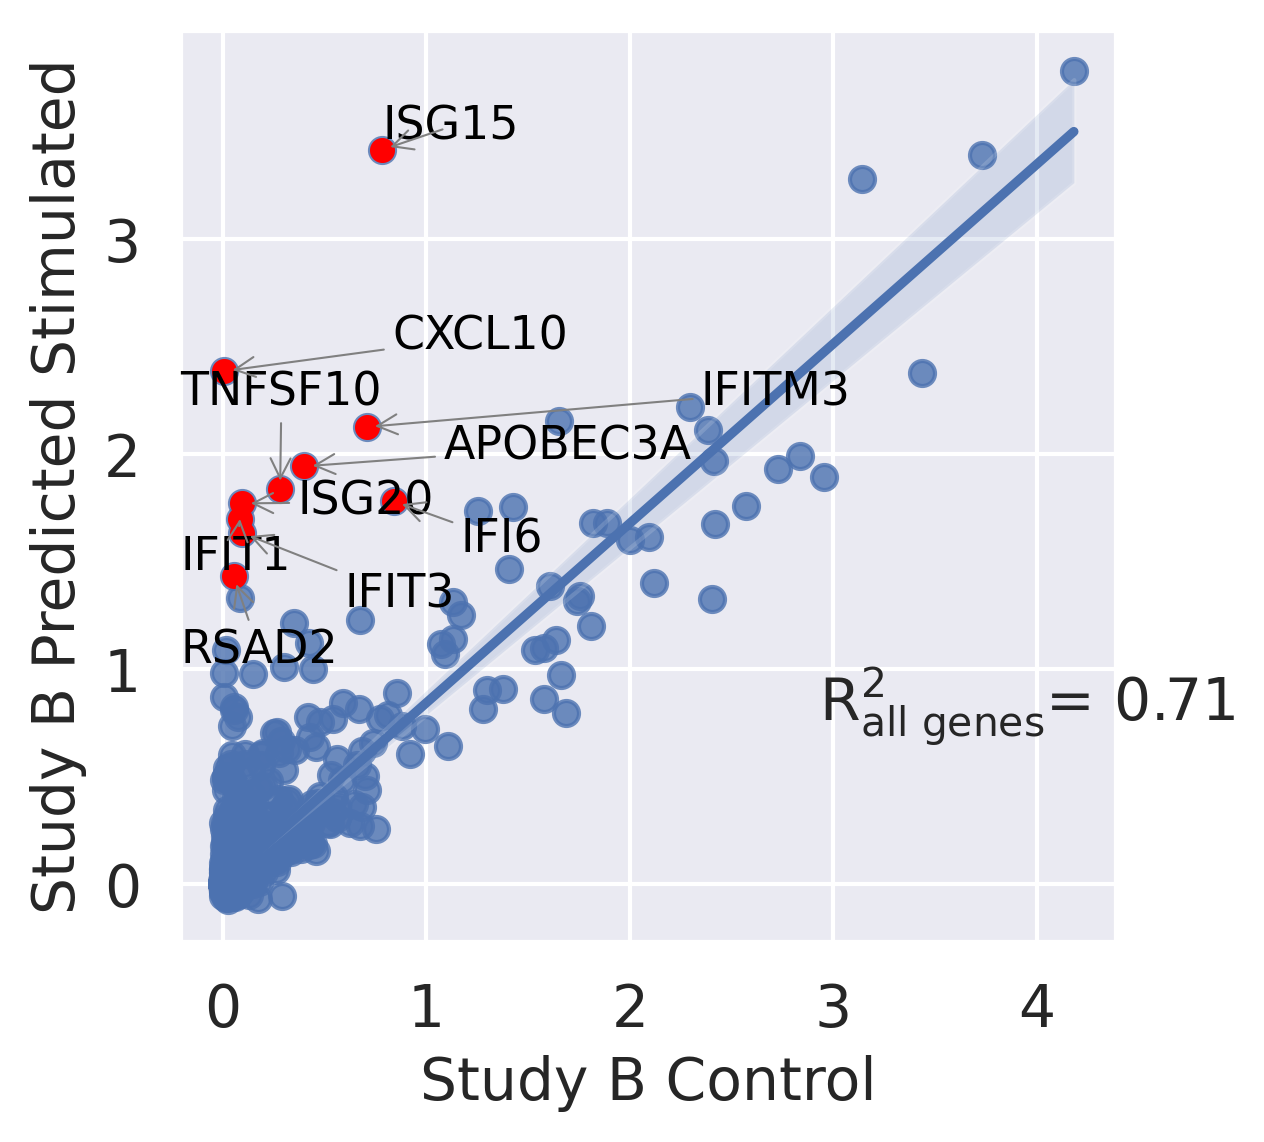

CD4T
INFO     Received view of anndata, making copy.                                                                    


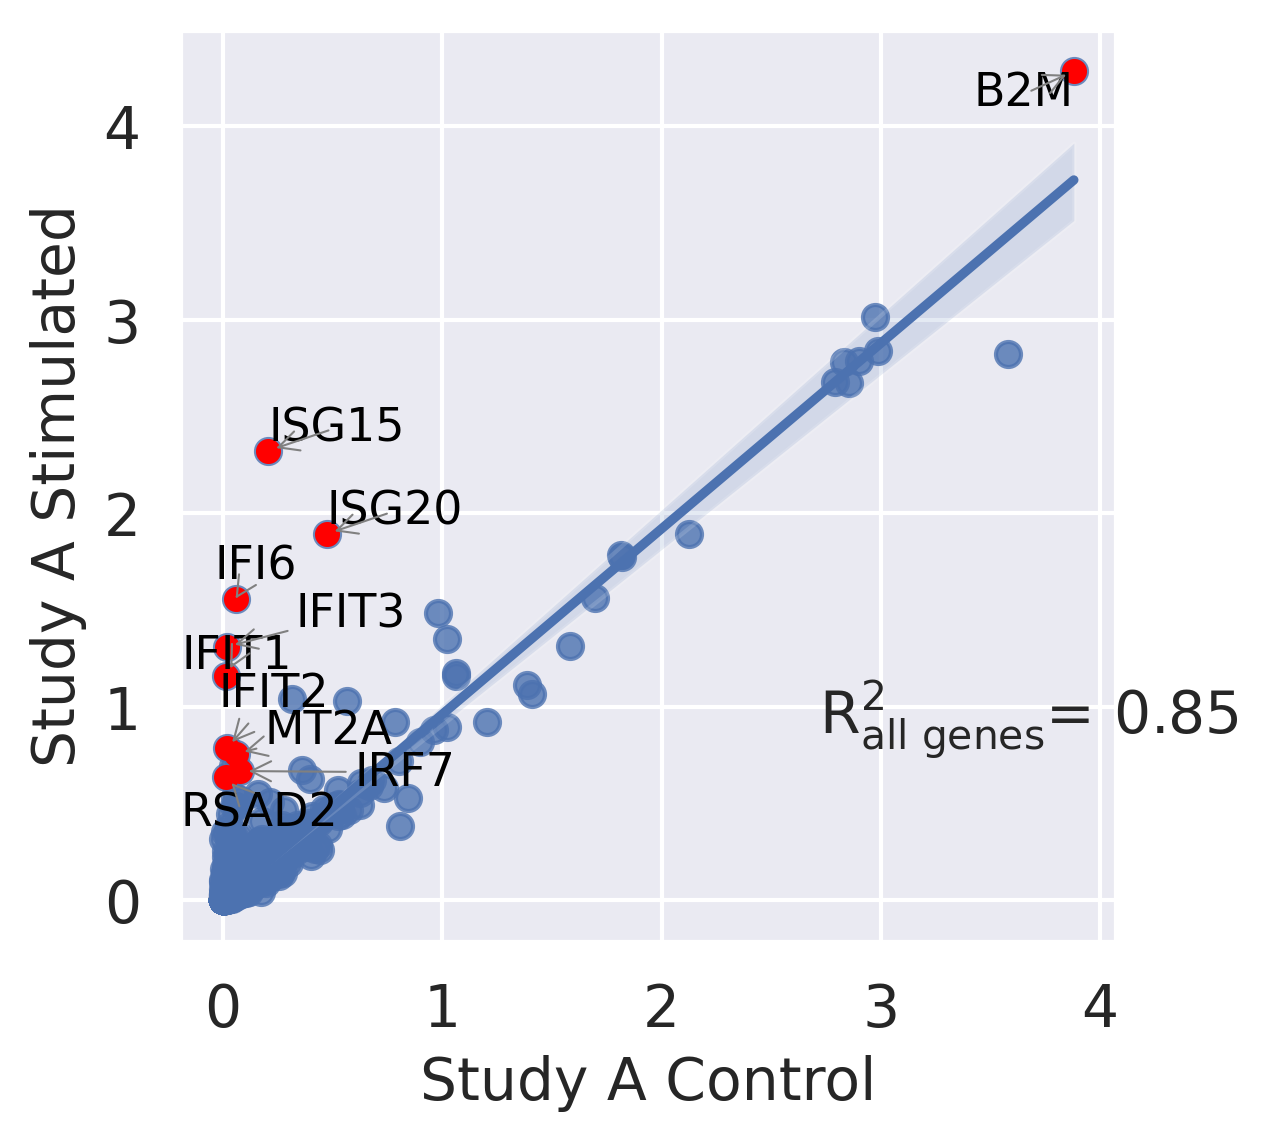

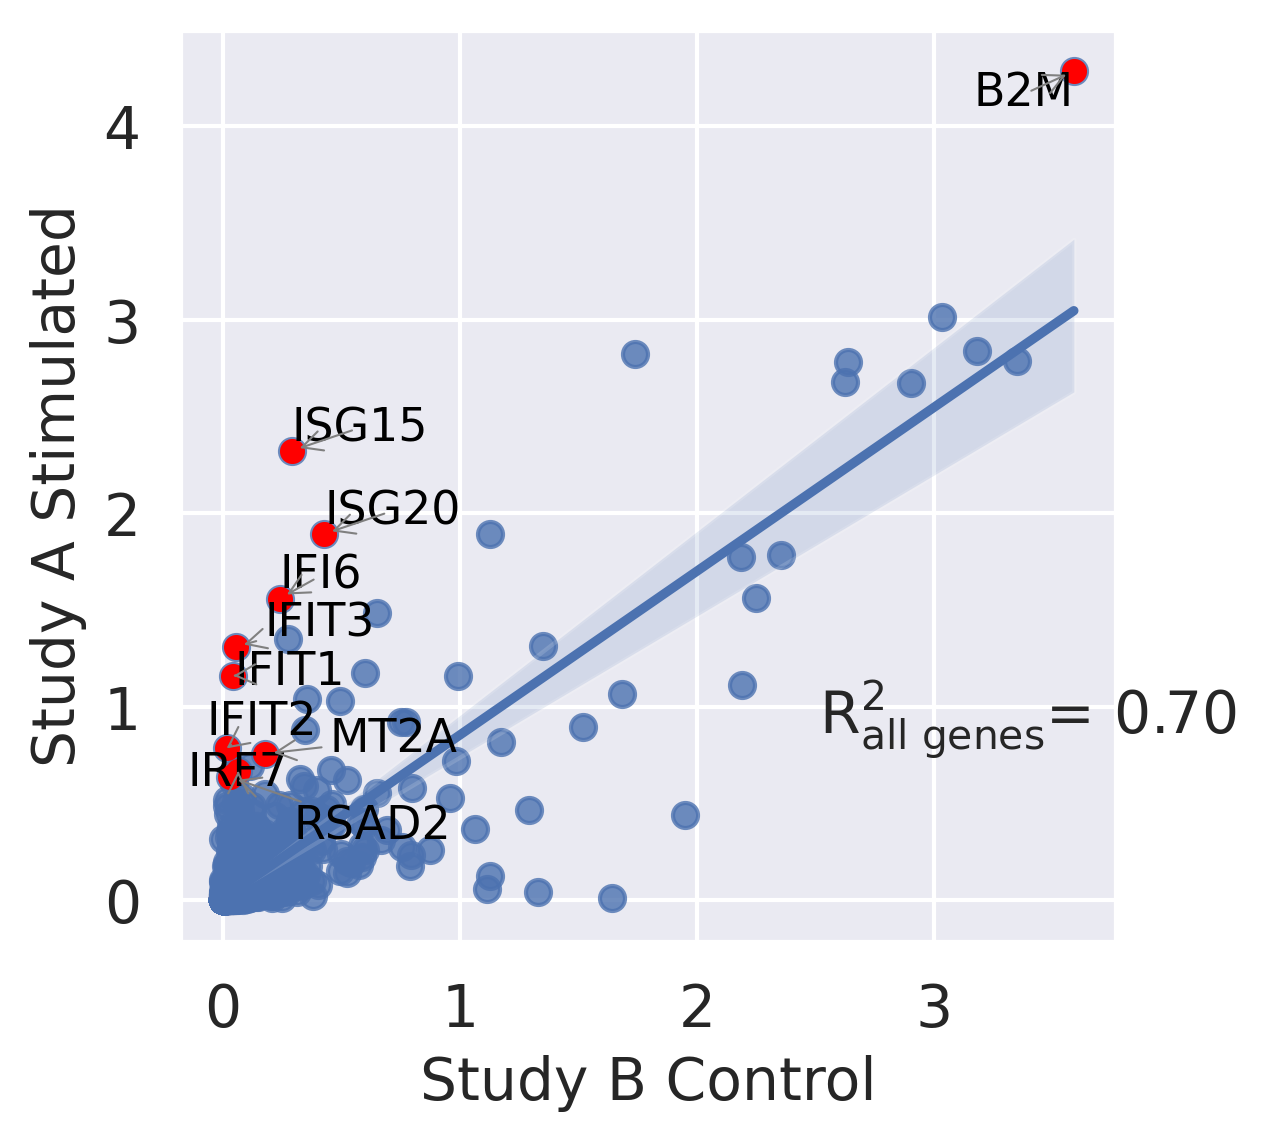

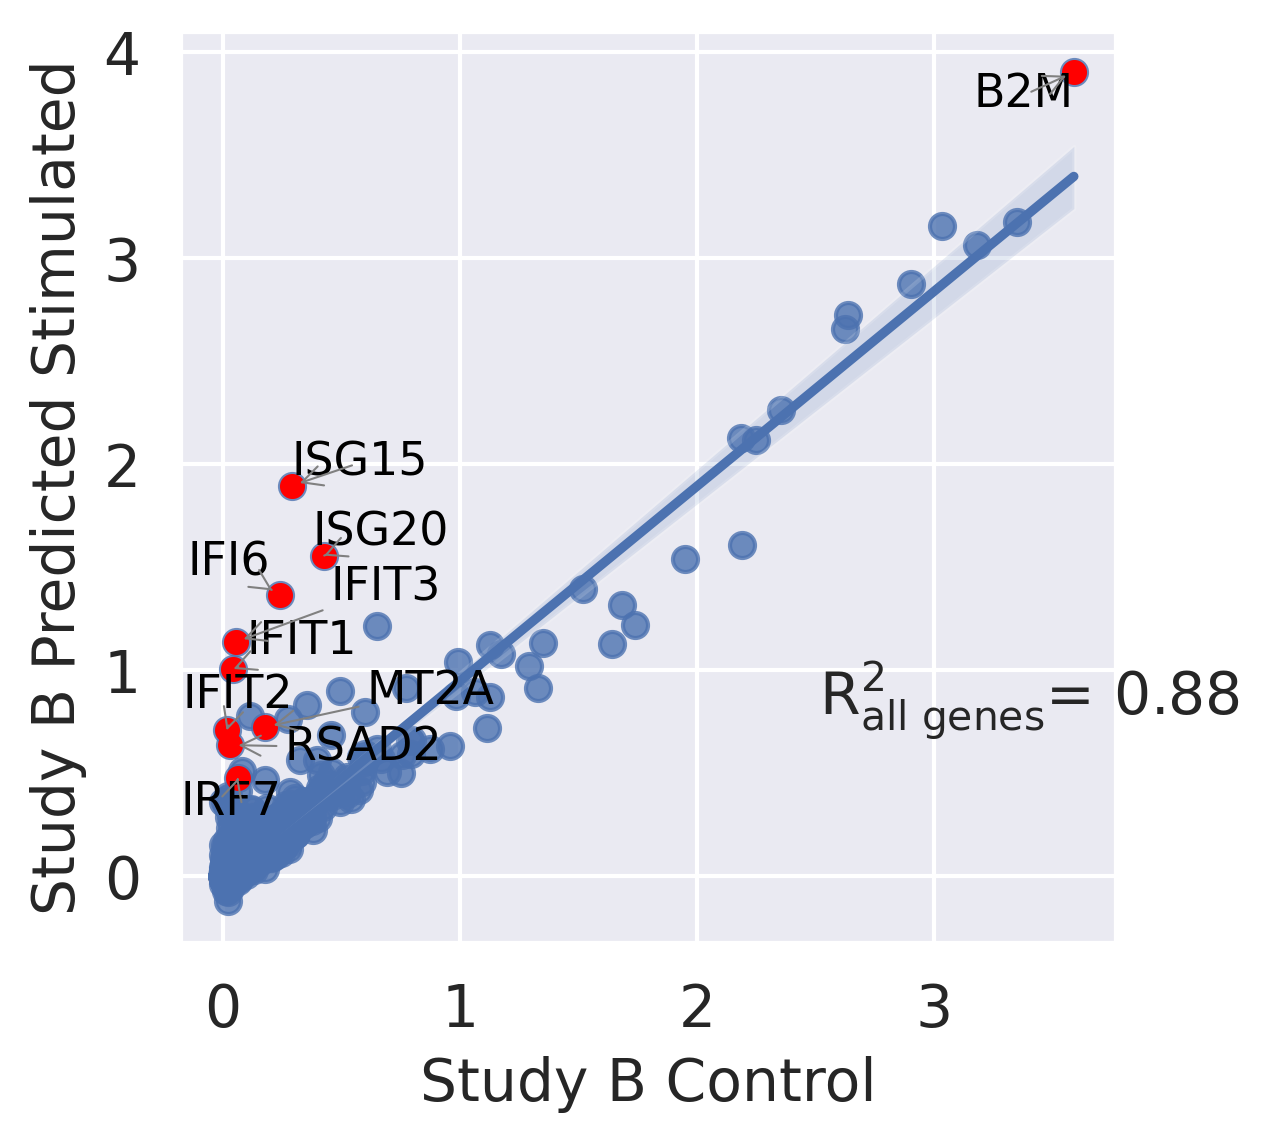

CD8T
INFO     Received view of anndata, making copy.                                                                    


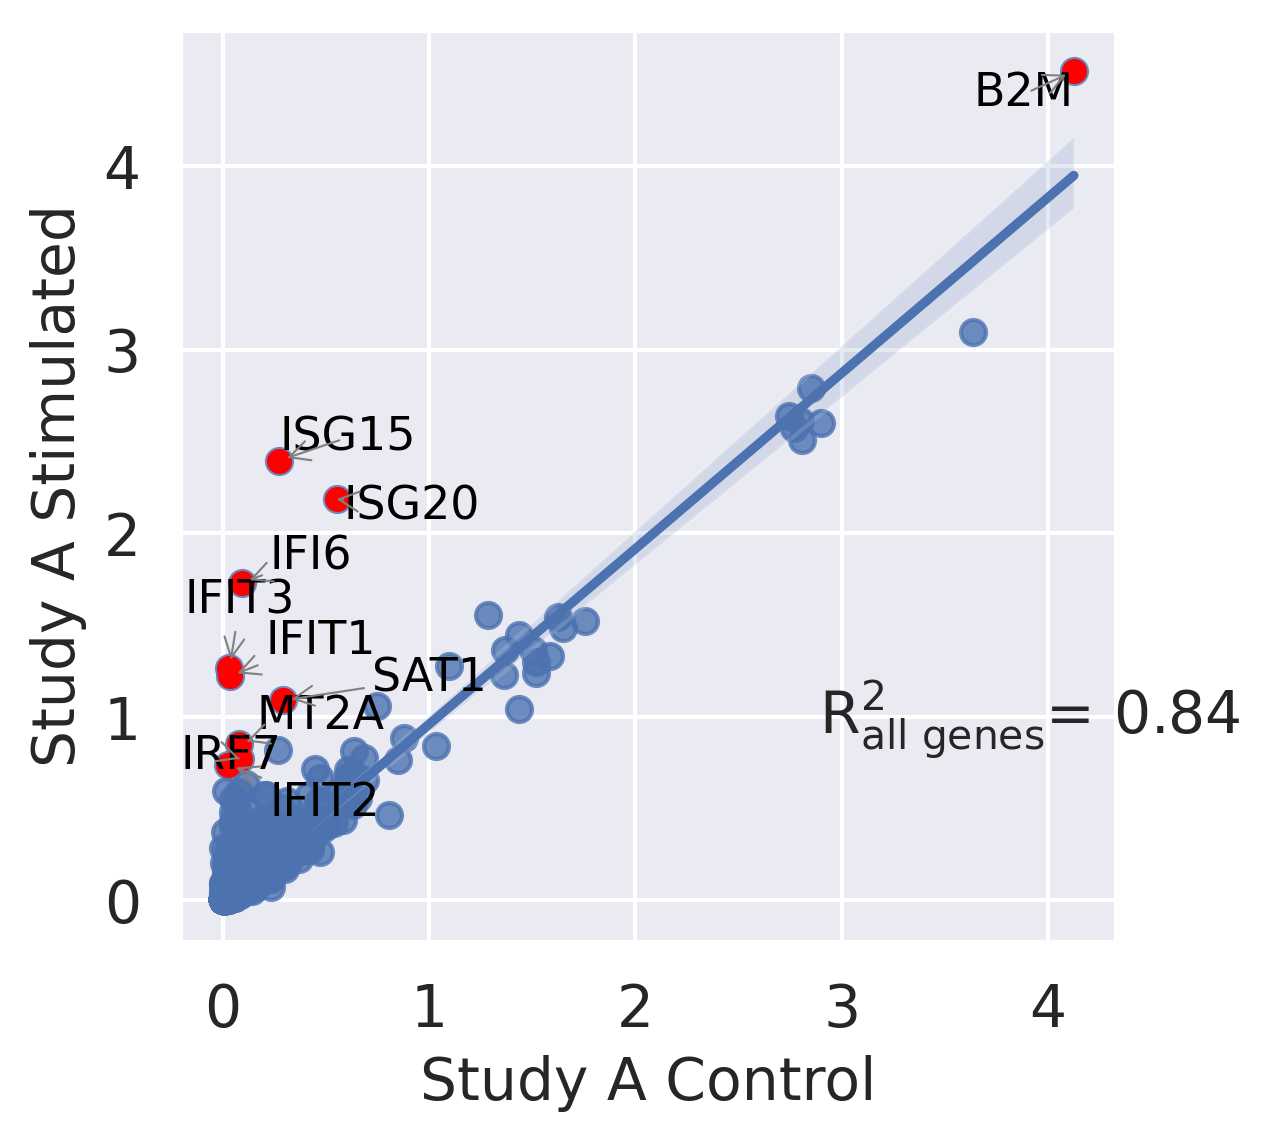

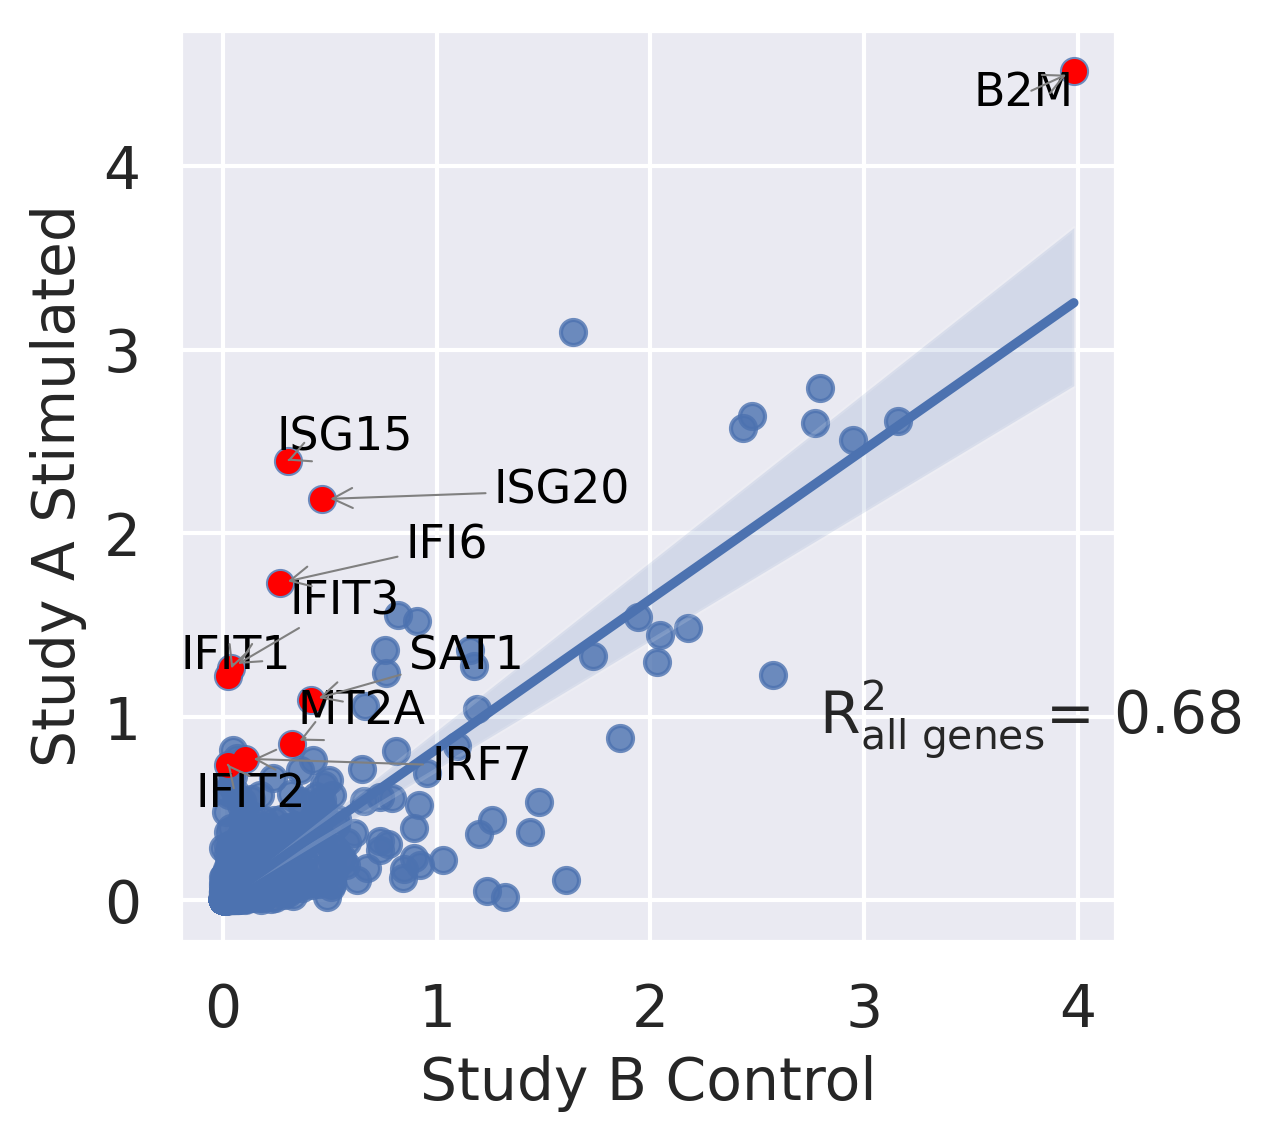

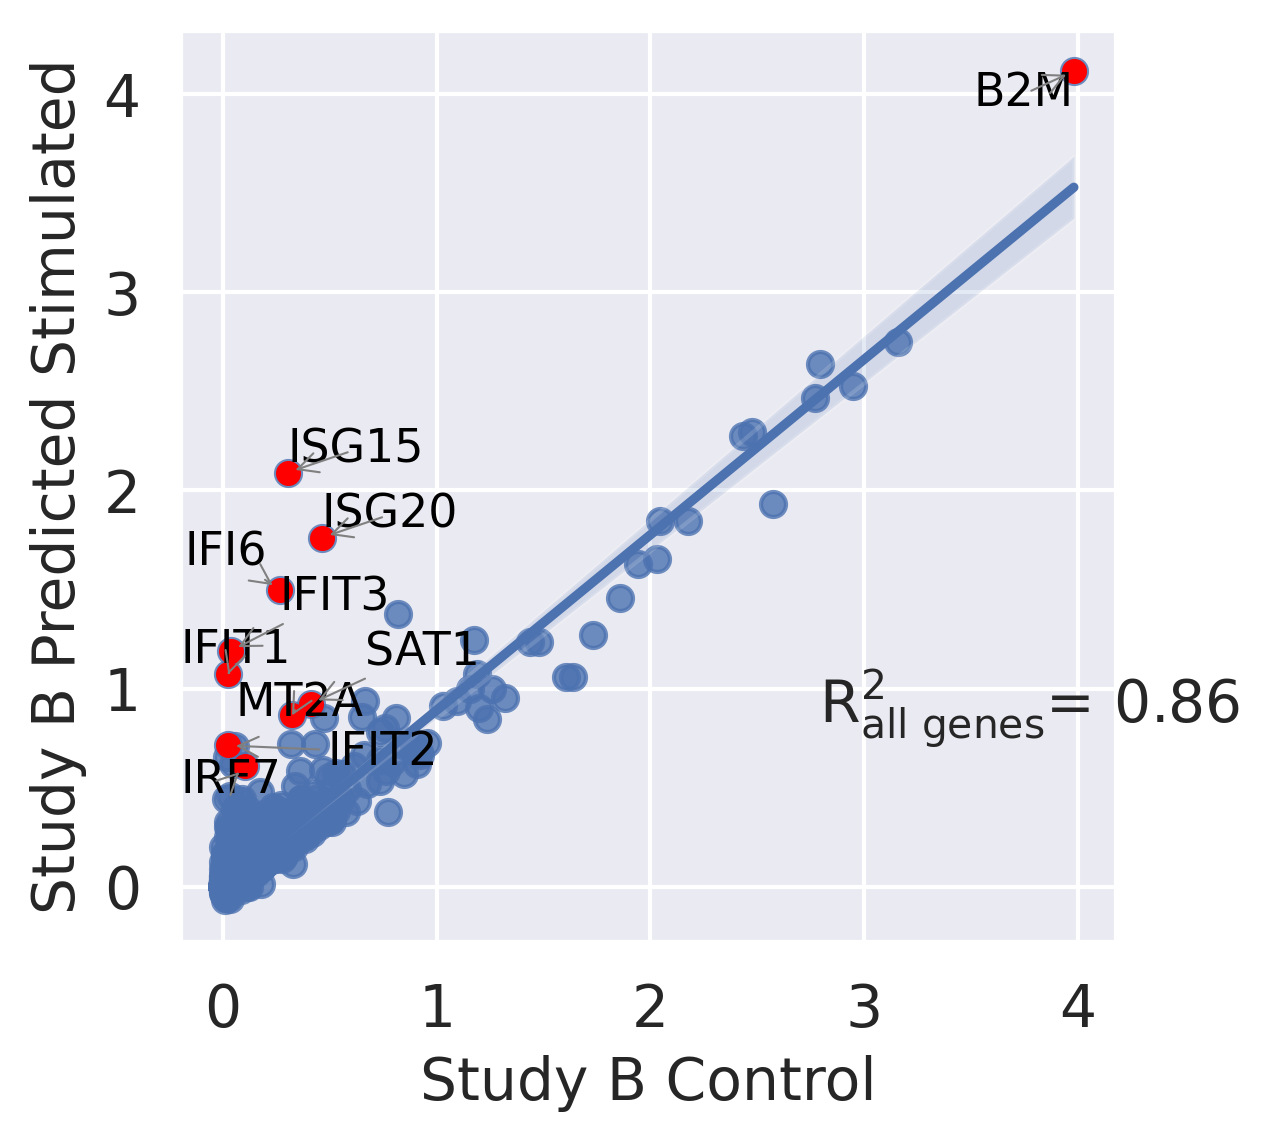

Dendritic
INFO     Received view of anndata, making copy.                                                                    


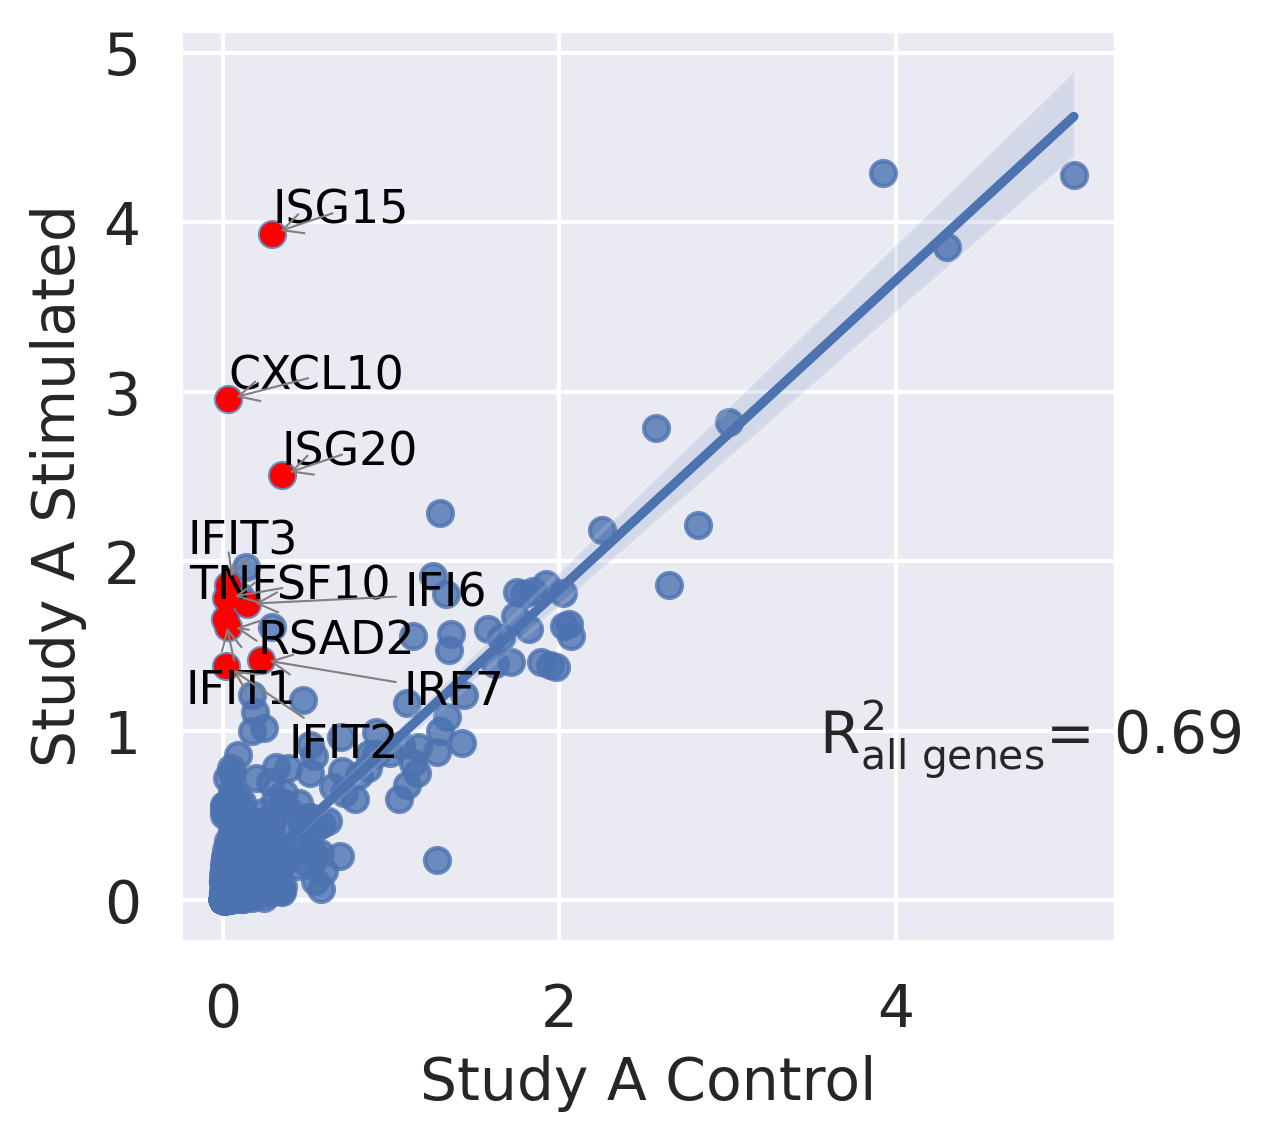

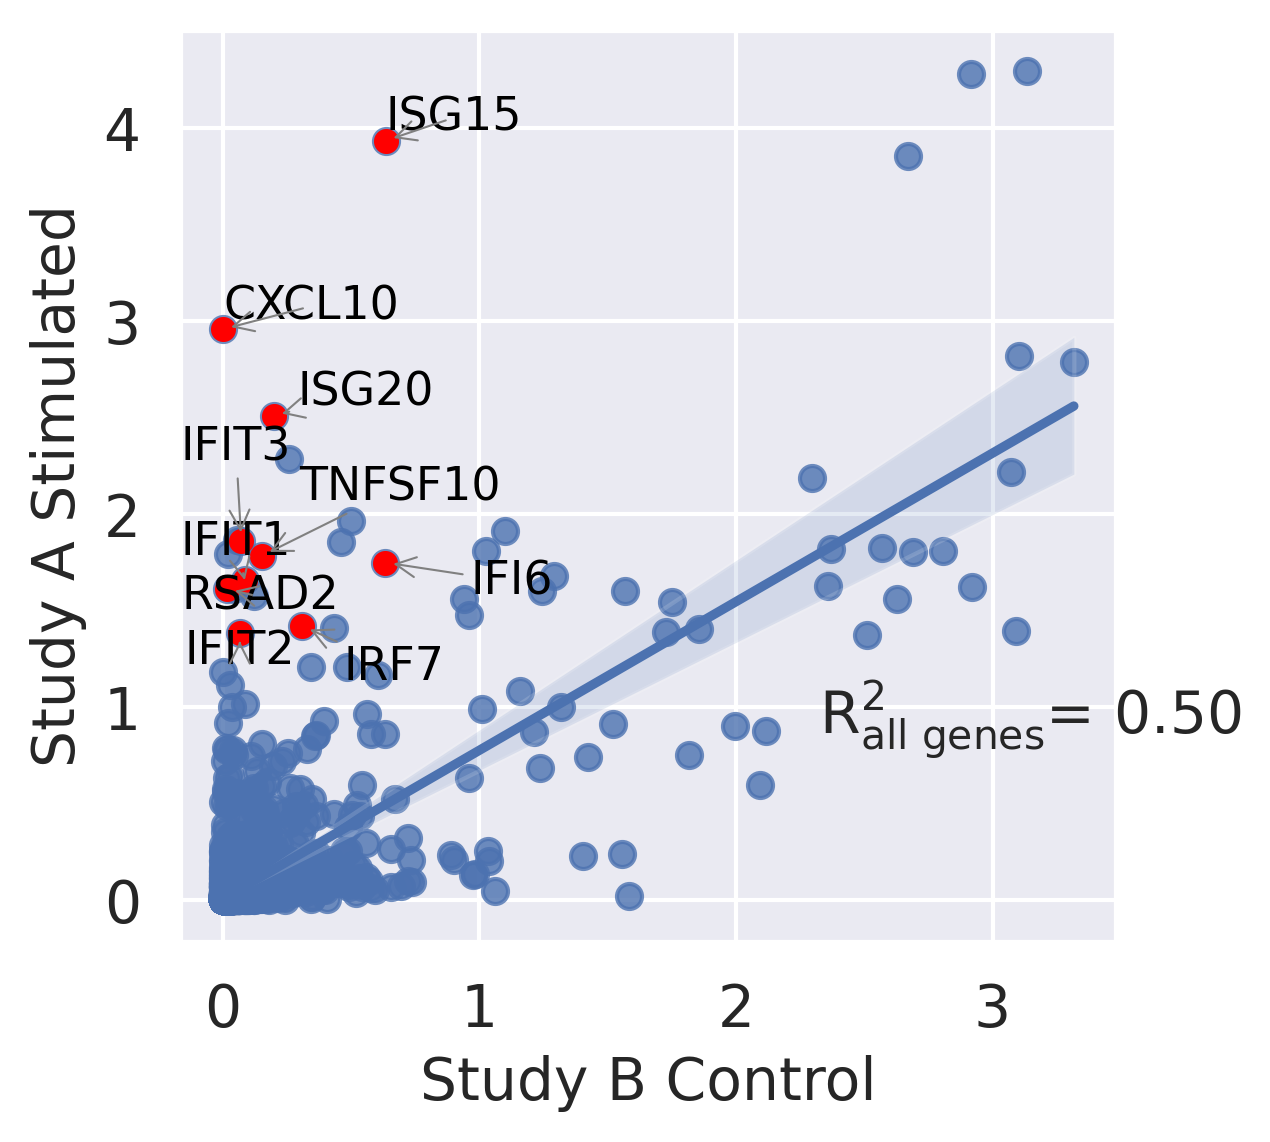

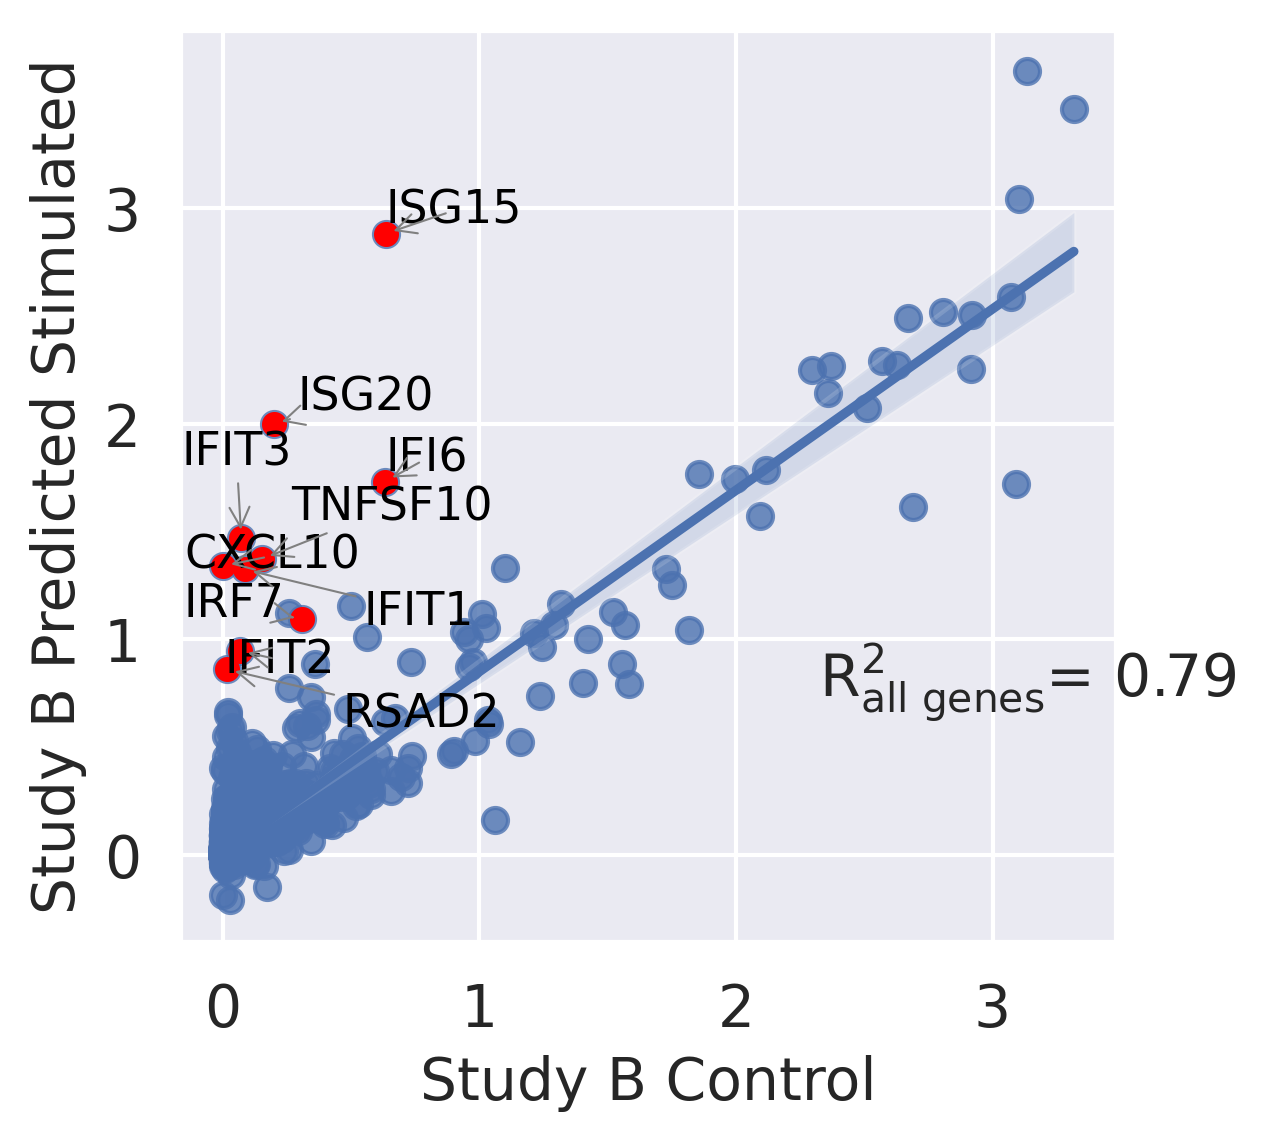

FCGR3A+Mono
INFO     Received view of anndata, making copy.                                                                    


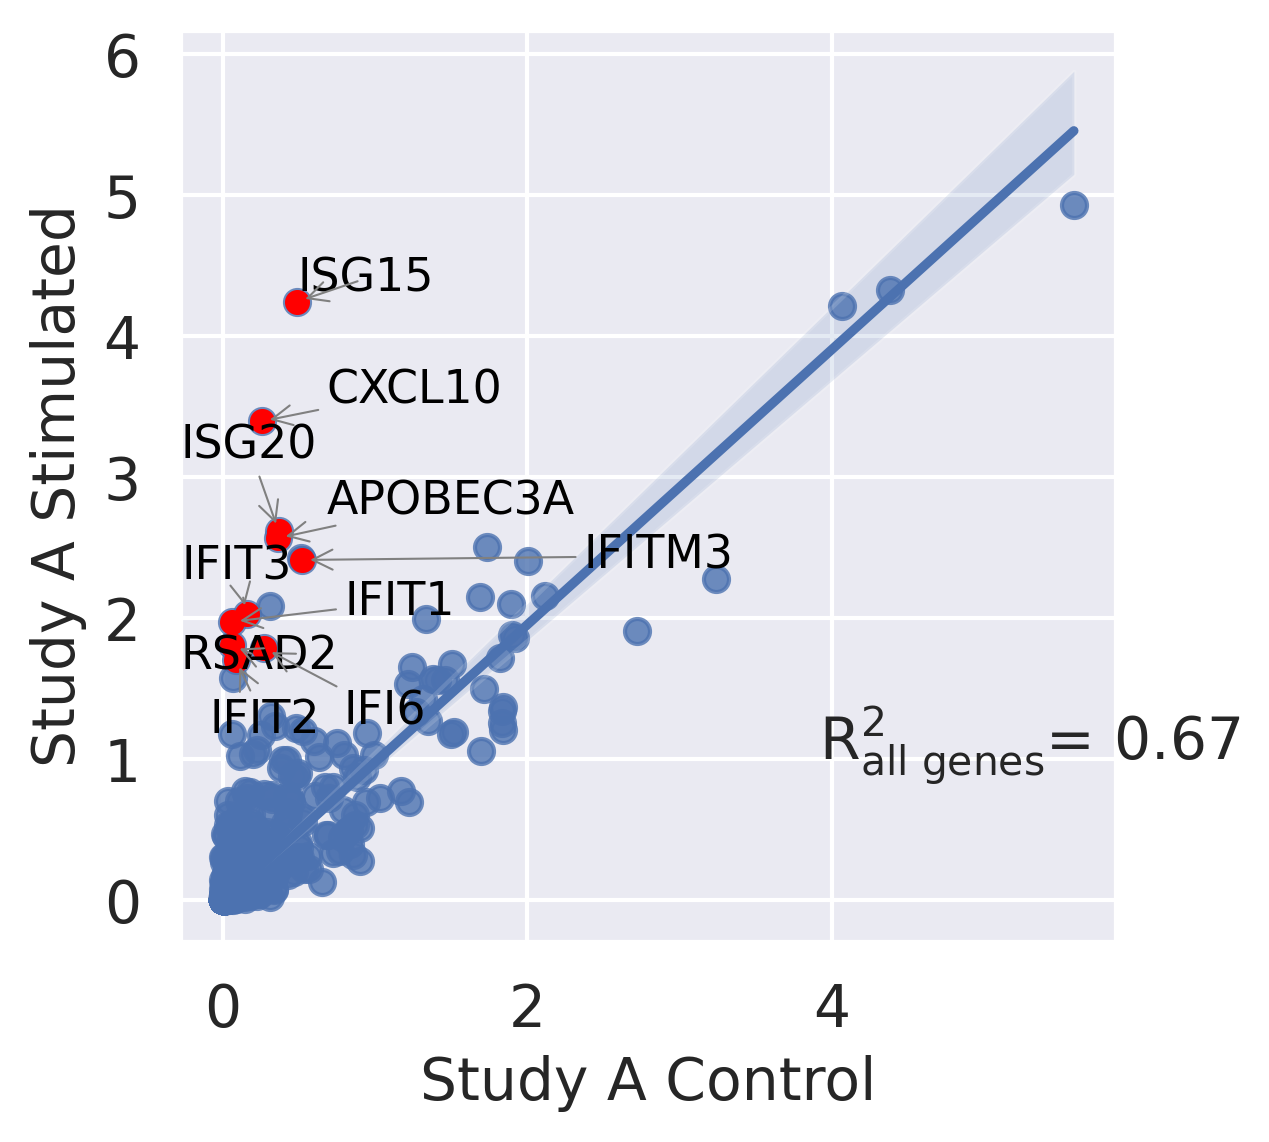

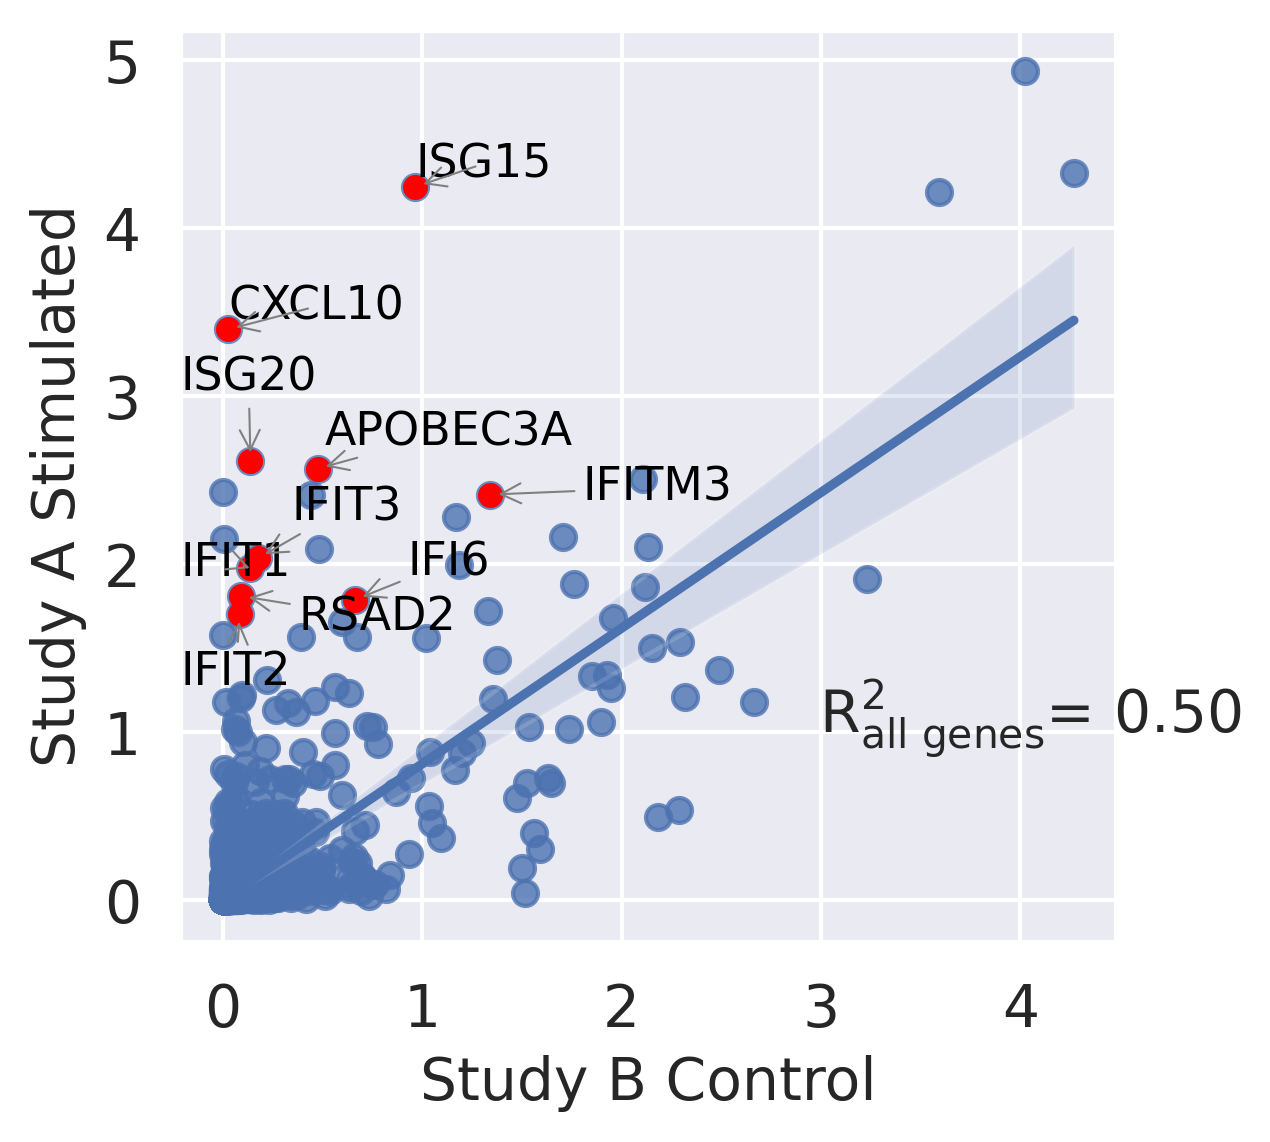

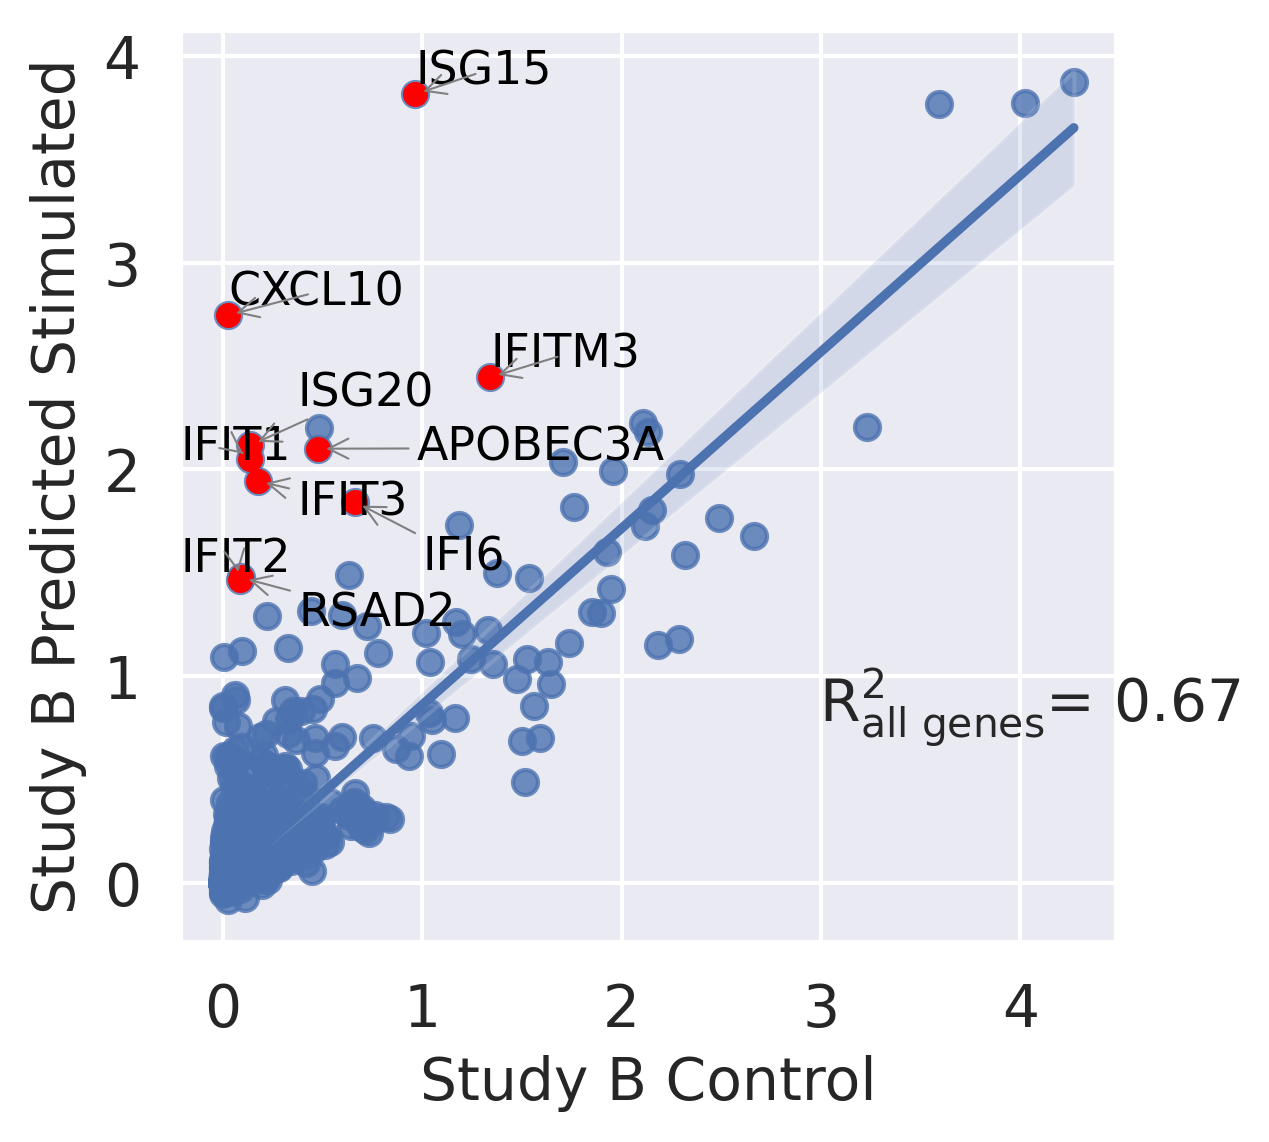

NK
INFO     Received view of anndata, making copy.                                                                    


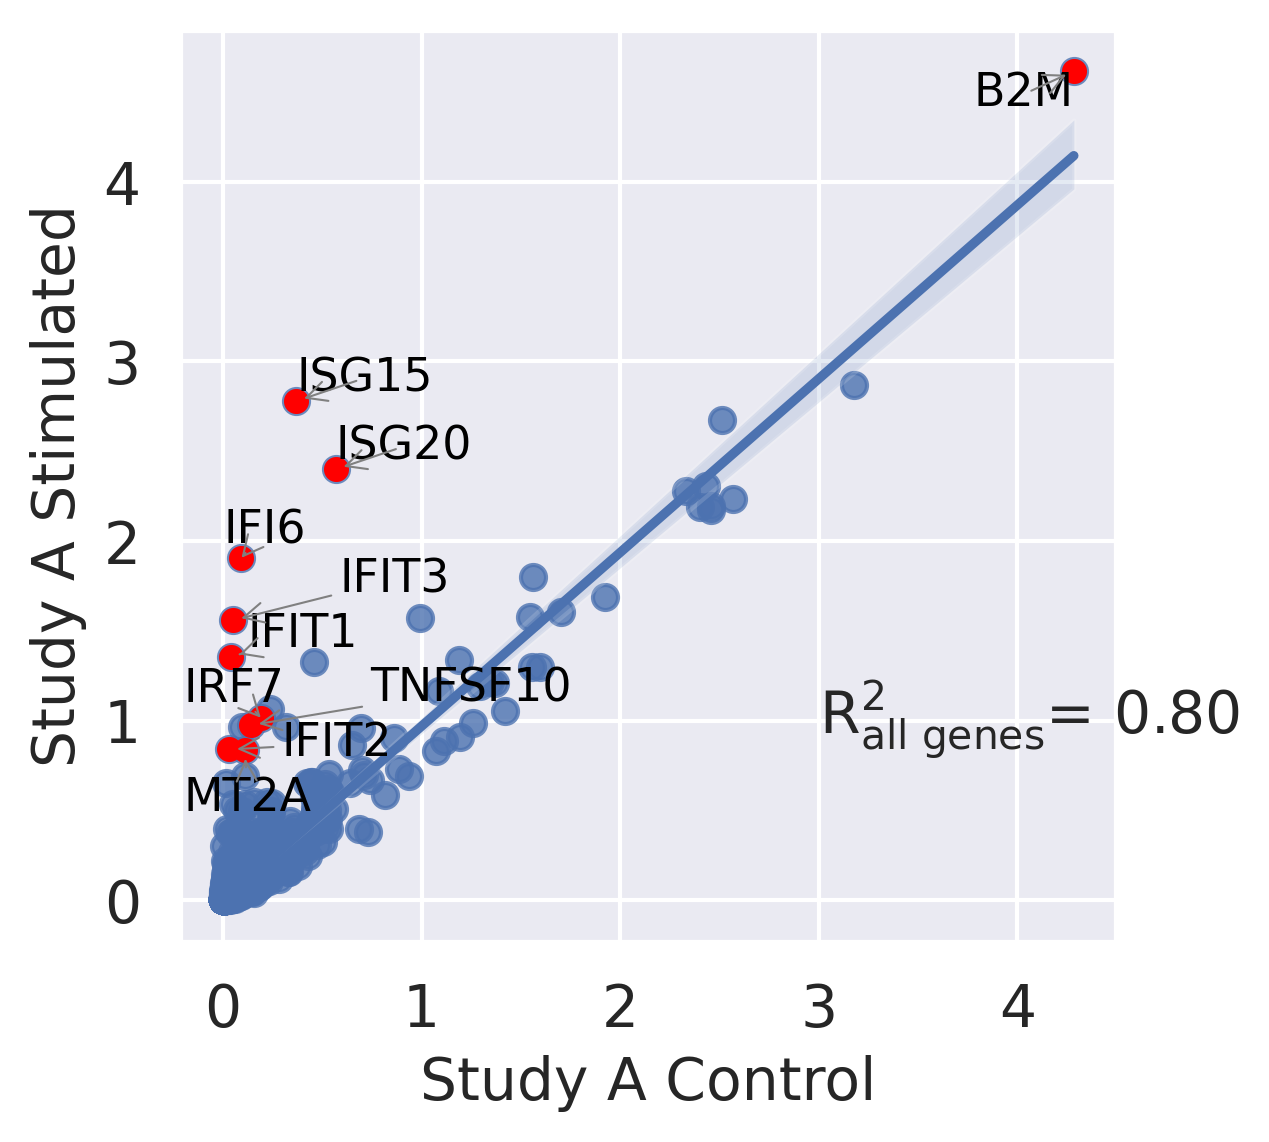

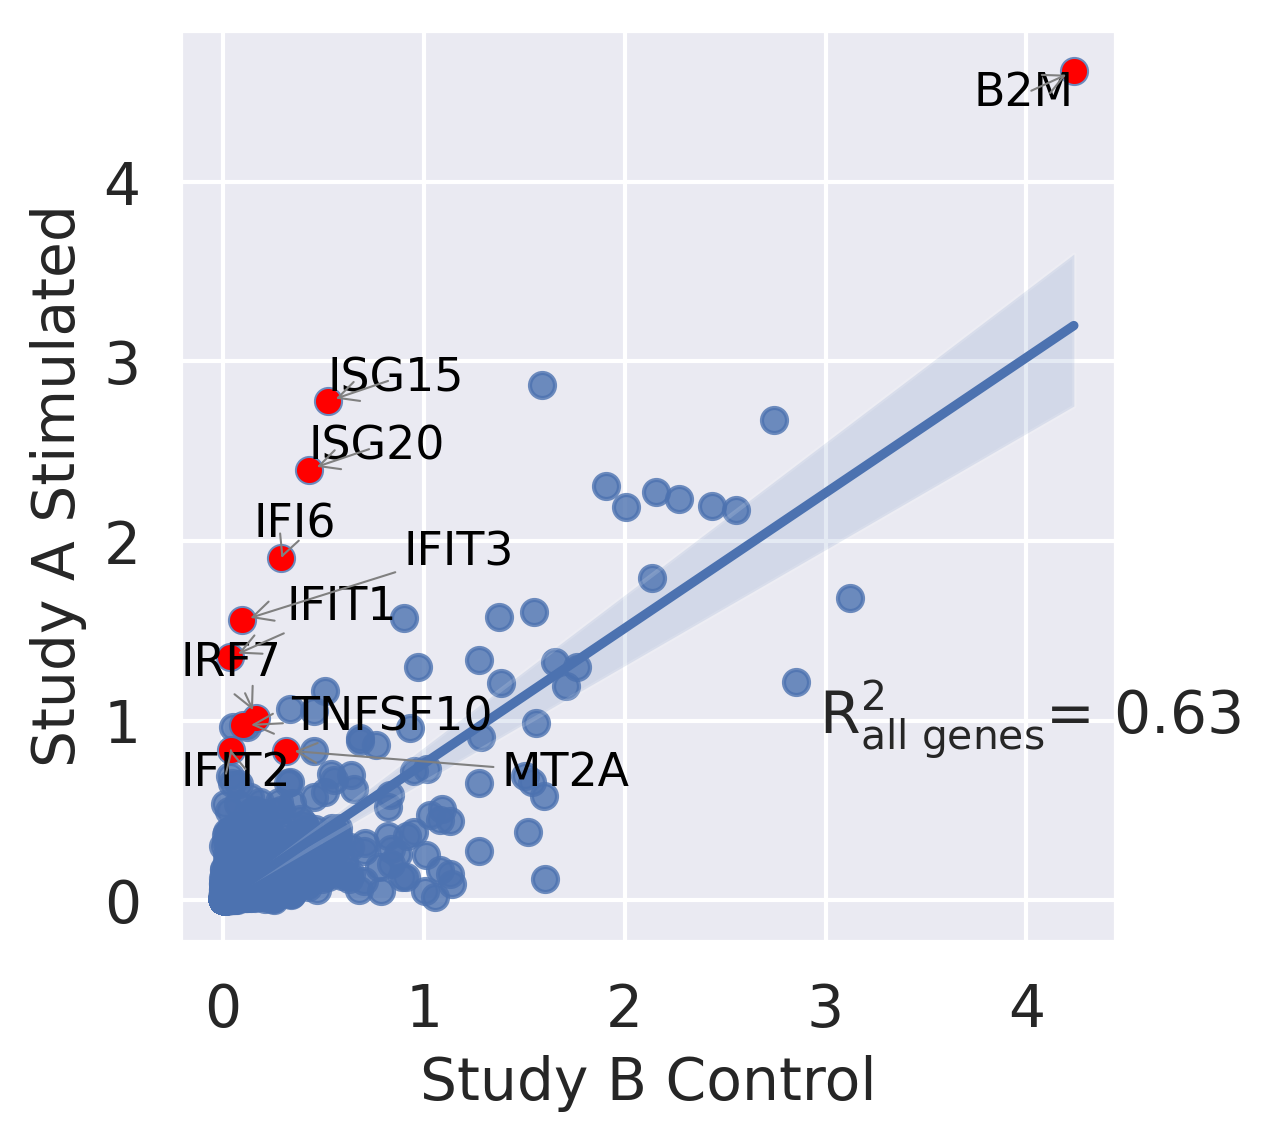

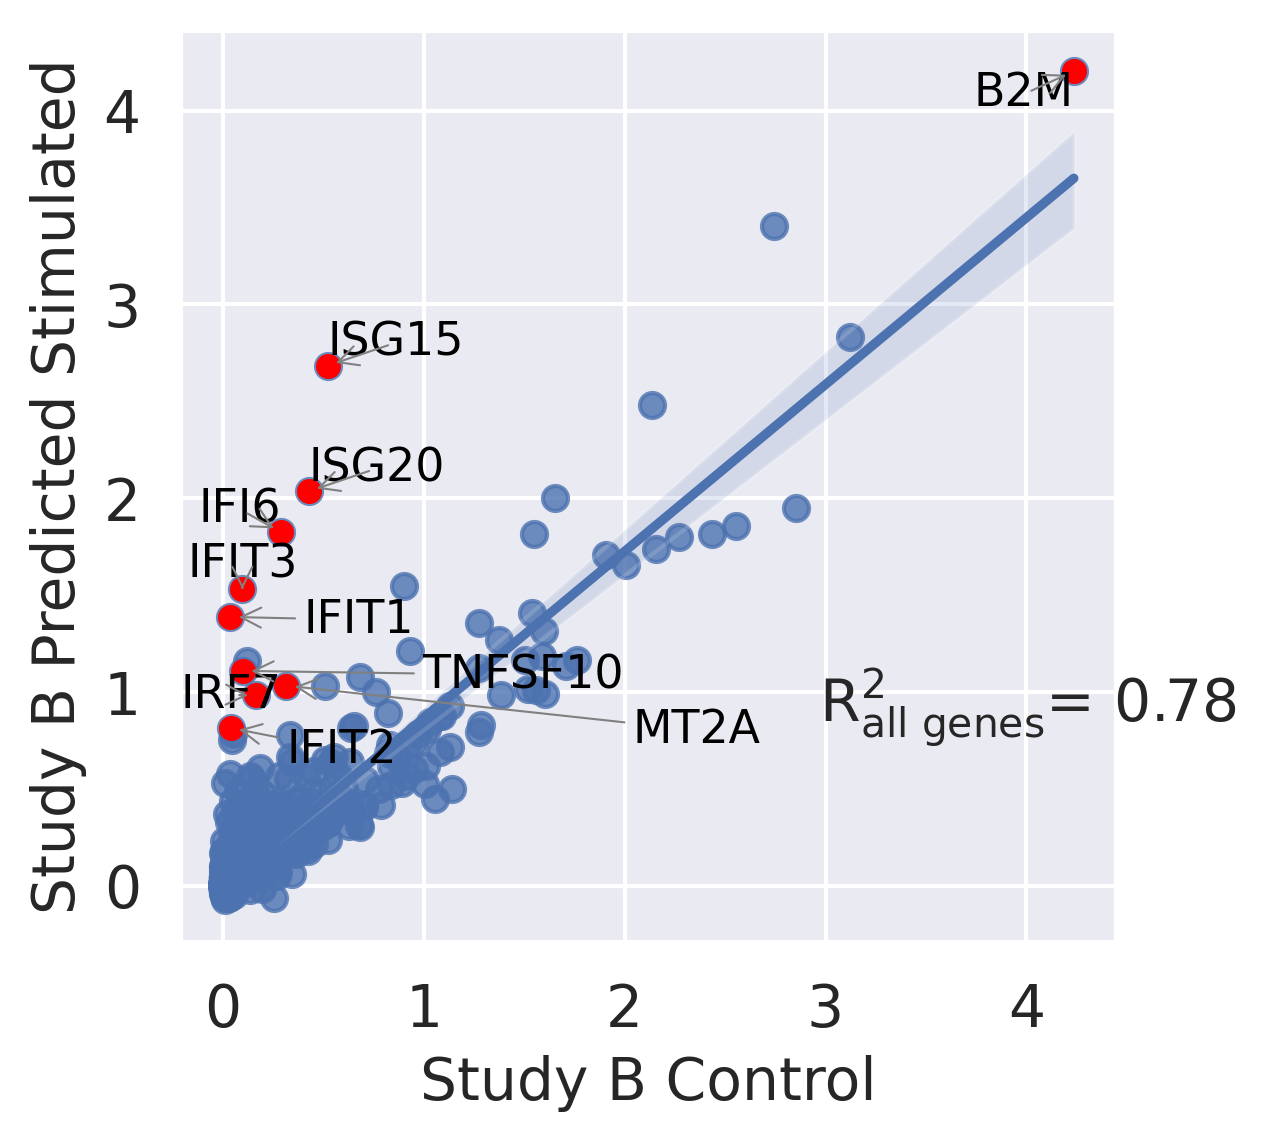

In [51]:
for cell_i in cell_types:
    print(cell_i)
    studyB_i = studyB[(studyB.obs[cell_type_key] == cell_i)]
    studyA_i = studyA[(studyA.obs[cell_type_key] == cell_i)]
    
    studyA_ctrl_i = studyA_i[(studyA_i.obs[treatment_key] == ctrl_key)]
    studyA_stim_i = studyA_i[(studyA_i.obs[treatment_key] == treat_key)]
    
    latent_cd_i = vae.get_latent_representation(studyB_i)
    scVIDR_delta_i = reg.predict([np.average(latent_cd_i, axis = 0)])[0]
    treat_pred = scVIDR_delta_i + latent_cd_i
    predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
    scvidr_pred_i = sc.AnnData(X=predicted_cells , obs=studyB_i.obs, var=studyB_i.var.copy())
    scvidr_pred_i.obs["condition"] = "pred"
    
    sc.tl.rank_genes_groups(studyA_i, groupby="condition", method="wilcoxon")
    diff_genes = studyA_i.uns["rank_genes_groups"]["names"]["stimulated"]
    
    eval_adata_A = studyA_i
    eval_adata_B = studyA_stim_i.concatenate(studyB_i)
    eval_adata_C = studyB_i.concatenate(scvidr_pred_i)
    
    r2_value = vae.reg_mean_plot(
        eval_adata_A,
        axis_keys={"x": "control", "y": "stimulated"},
        labels={"x": "Study A Control", "y": "Study A Stimulated"},
        gene_list=diff_genes[:10],
        path_to_save="../figures/Figure2C2.svg",
        show=True,
        legend=False,)
    
    r2_value = vae.reg_mean_plot(
        eval_adata_B,
        axis_keys={"x": "control", "y": "stimulated"},
        labels={"x": "Study B Control", "y": "Study A Stimulated"},
        gene_list=diff_genes[:10],
        path_to_save="../figures/Figure2C2.svg",
        show=True,
        legend=False,)
    
    r2_value = vae.reg_mean_plot(
       eval_adata_C,
       axis_keys={"x": "control", "y": "pred"},
        labels={"x": "Study B Control", "y": "Study B Predicted Stimulated"},
        gene_list=diff_genes[:10],
        path_to_save="../figures/Figure2C2.svg",
        show=True,
        legend=False,)
    

In [40]:
df_list = []

for cell_i in cell_types:
    print(cell_i)
    studyB_i = studyB[(studyB.obs[cell_type_key] == cell_i)]
    studyA_i = studyA[(studyA.obs[cell_type_key] == cell_i)]
    
    studyA_ctrl_i = studyA_i[(studyA_i.obs[treatment_key] == ctrl_key)]
    studyA_stim_i = studyA_i[(studyA_i.obs[treatment_key] == treat_key)]
    
    latent_cd_i = vae.get_latent_representation(studyB_i)
    scVIDR_delta_i = reg.predict([np.average(latent_cd_i, axis = 0)])[0]
    treat_pred = scVIDR_delta_i + latent_cd_i
    predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
    scvidr_pred_i = sc.AnnData(X=predicted_cells , obs=studyB_i.obs, var=studyB_i.var.copy())
    scvidr_pred_i.obs["condition"] = "pred"
    
    sc.tl.rank_genes_groups(studyA_i, groupby="condition", method="wilcoxon")
    diff_genes = studyA_i.uns["rank_genes_groups"]["names"]["stimulated"]
    
    eval_adata_A = studyA_i
    eval_adata_B = studyA_stim_i.concatenate(studyB_i)
    eval_adata_C = studyB_i.concatenate(scvidr_pred_i)
    
    r2_df1 = calculate_r2_singledose(
        eval_adata_B, cell_i,
        "Study A Stim vs. Study B Ctrl", 
        "condition", 
        {"x":"control", "y":"stimulated"},
        random_sample_coef = 0.8,
        n_iter = 100
    )
    
    df_list.append(r2_df1)
    
    r2_df2 = calculate_r2_singledose(
        eval_adata_C, cell_i,
        "Study B Pred vs. Study B Ctrl", 
        "condition", 
        {"x":"control", "y":"pred"},
        random_sample_coef = 0.8,
        n_iter = 100
    )
    
    df_list.append(r2_df2)

B
INFO     Received view of anndata, making copy.                                                                    
CD14+Mono
INFO     Received view of anndata, making copy.                                                                    
CD4T
INFO     Received view of anndata, making copy.                                                                    
CD8T
INFO     Received view of anndata, making copy.                                                                    
Dendritic
INFO     Received view of anndata, making copy.                                                                    
FCGR3A+Mono
INFO     Received view of anndata, making copy.                                                                    
NK
INFO     Received view of anndata, making copy.                                                                    


In [41]:
r2_values_allCells_df = pd.concat(df_list)

In [42]:
r2_values_allCells_df["Study Comparison"] = r2_values_allCells_df["Model"]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'B'),
  Text(1, 0, 'CD14+Mono'),
  Text(2, 0, 'CD4T'),
  Text(3, 0, 'CD8T'),
  Text(4, 0, 'Dendritic'),
  Text(5, 0, 'FCGR3A+Mono'),
  Text(6, 0, 'NK')])

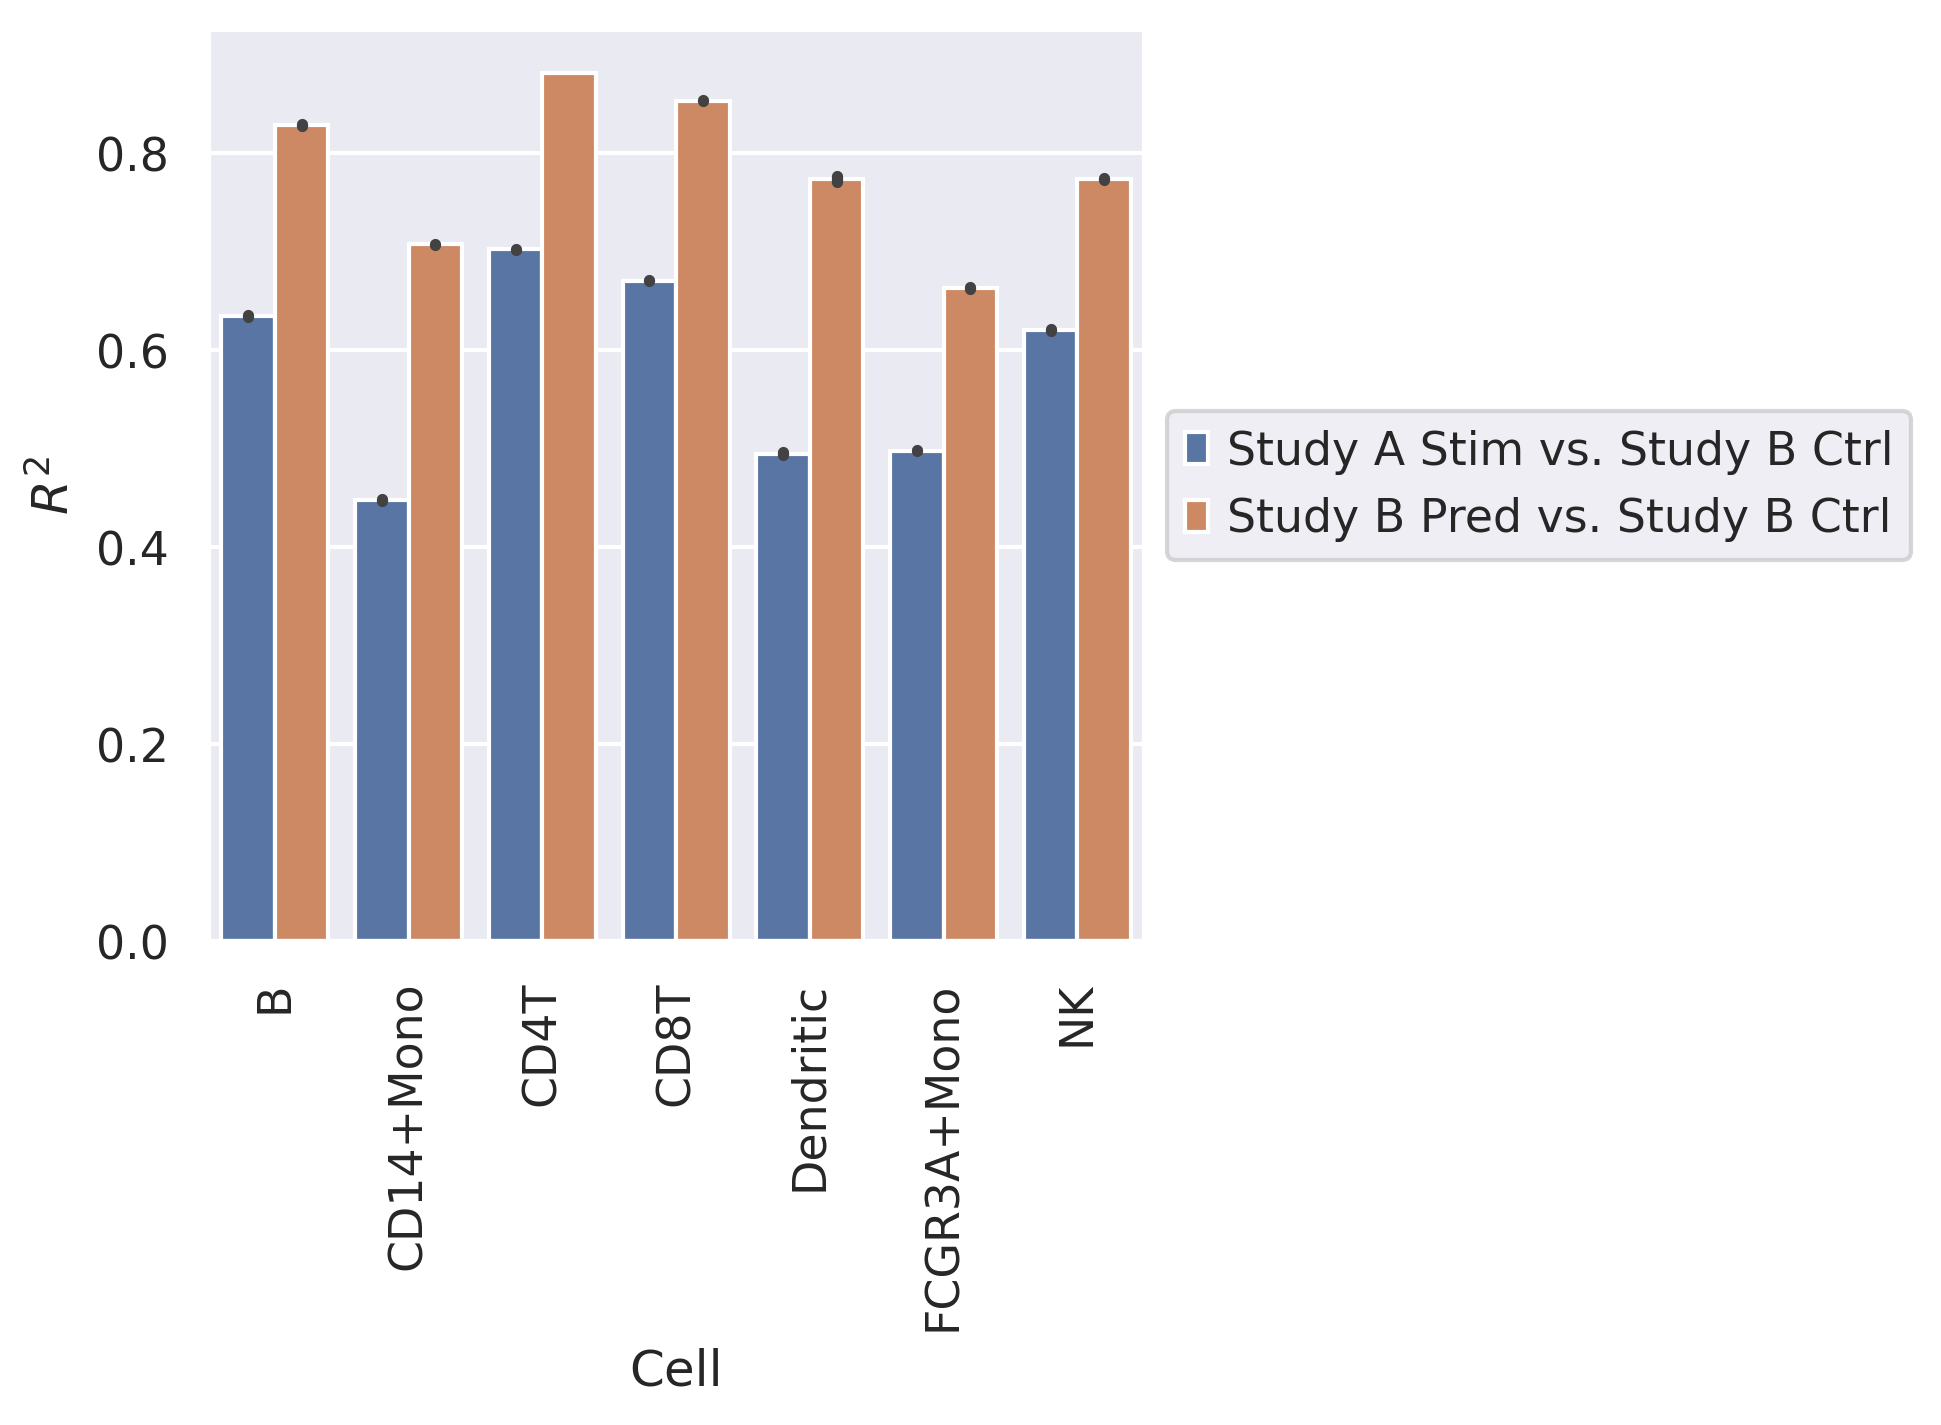

In [50]:
hue_order = ["Study A Stim vs. Study B Ctrl","Study B Pred vs. Study B Ctrl"]
ax = sns.barplot(x = "Cell", y = "R^2",  data = r2_values_allCells_df, hue = "Study Comparison", hue_order = hue_order)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel(r"$R^2$")
plt.xticks(rotation = 90)